<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>
<img src="images\GRU_derivatives.jpg" width=800>

In [95]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            if ord(c)-ord('A') > 0 and ord(c)-ord('A') < dimensions:
                new_data = []
                for i in range(0, dimensions):
                    new_data.append([0])
                    
                new_data[ord(c)-ord('A')] = [1]
                data.append(new_data)
                if max_len != None:
                    if len(data) >= max_len:
                        print("all loaded")    
                        return data
                    
    print("all loaded")    
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]        # Takes in the output of the previous layer. h[-1] is the hidden state of the last timestep of the layer
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].h[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
    
    def predict(self, input_data):
        next_letter = []
        out_letter = []
        for i in range(0, len(input_data)):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(500, 700):
            maximum = 0;
            max_index = 0;
            for k in range(0, self.layers[0].input_size):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k
            out_letter = np.empty(next_letter.shape)
            out_letter.fill(0)
            out_letter[max_index,0] = 1
            print_output += chr(ord('A')+max_index)
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # M
        self.output_size = output_size # N
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
    def weights_init(self, rows, cols, bias=False):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(0,0.01,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data):
        
        self.inputs = np.append(self.inputs, [input_data])
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.empty((self.h.shape[1], self.h.shape[2]))
            prev_h.fill(0)
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz      #Nx1
        new_z = activation_function(new_z, "sigmoid")
        #print("=======")
        #print("io : ", self.input_size, self.output_size)
        #print("shapes: ", self.Wz.shape,' @ ',len(input_data),'+',self.Uz.shape,' @ ',prev_h.shape,'+',self.bz.shape)
        #print("new_z: ",new_z.shape)
        #print("z: ", self.z)
        #print("=======")
        #print("new_z: ", new_z)
        #print("=======")
        #print("z and new z -> ",self.z.shape, new_z.shape)
        #print("=======")
        if(self.z.shape[0]>=1):
            #self.z = np.append(self.z, [new_z], axis=0)
            self.z = np.vstack((self.z,new_z[None]))
        else:
            new_z = new_z.reshape((1,new_z.shape[0], new_z.shape[1]))
            self.z = new_z
        #print("Finally : ", self.z)
        
        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = activation_function(new_r, "sigmoid")
        self.r = np.append(self.r, [new_r], axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.r[-1] * (self.Uh @ prev_h) + self.bh
        new_h_tilde = activation_function(new_h_tilde, "tanh")
        self.h_tilde = np.append(self.h_tilde, [new_h_tilde], axis=0)
        
        new_h = self.z[-1] * self.h_tilde[-1] + (1 - self.z[-1]) * prev_h
        if self.last_activation != None:
            new_h = activation_function(new_h, self.last_activation)
        self.h = np.append(self.h, [new_h], axis=0)
        
        
        if len(self.z) > 30:
            self.z = np.delete(self.z, 0, 0)
        if len(self.r) > 30:
            self.r = np.delete(self.r, 0, 0)
        if len(self.h_tilde) > 30:
            self.h_tilde = np.delete(self.h_tilde, 0, 0)
        if len(self.h) > 30:
            self.h = np.delete(self.h, 0, 0)
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(self.h[-1] - target) * activation_function(self.h[-1], self.last_activation, derivative=True, activated_value=self.h[-1]), np.power(target - self.h[-1], 2)
        return 2*(self.h[-1] - target), np.power(target - self.h[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        first_index = max(len(self.h) - max_steps, 0)
        
        step = 0
        """-----------------INPUTS RESHAPED------------------"""
        
        inputs_reshaped = np.array(input_data[0])
        inputs_reshaped_here = inputs_reshaped.T
        
        """------------------Wr t=0 checked------------------"""
        
        dr_Wr = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        dr_Wr = np.tile(dr_Wr, (1, self.input_size))
        dr_Wr = dr_Wr * inputs_reshaped_here
        
        dz_Wr = np.zeros((self.output_size, self.input_size))
        dhtilde_Wr = np.zeros((self.output_size, self.input_size))
        dh_Wr = np.zeros((self.output_size, self.input_size))
        
        """------------------Wz t=0 checked------------------"""
        
        dr_Wz = np.zeros((self.output_size, self.input_size))
        
        dz_Wz = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_Wz = np.tile(dz_Wz, (1, self.input_size))
        dz_Wz = dz_Wz * inputs_reshaped_here
        
        dhtilde_Wz = np.zeros((self.output_size, self.input_size))
        dh_Wz = dz_Wz * (-self.h_tilde[first_index])
        
        """------------------Uz t=0 checked------------------"""
        
        dz_Uz = np.zeros((self.output_size, self.output_size))
        
        dr_Uz = np.zeros((self.output_size, self.output_size))
        
        dhtilde_Uz = np.zeros((self.output_size, self.output_size))
        
        dh_Uz = np.zeros((self.output_size, self.output_size))
        
        """------------------bz t=0 checked------------------"""
        
        dz_bz = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        
        dr_bz = np.zeros((self.output_size, 1))
        
        dhtilde_bz = np.zeros((self.output_size, 1))
        
        dh_bz = dz_bz * (-self.h_tilde[first_index])
        
        """------------------br t=0 checked------------------"""
        
        dz_br = np.zeros((self.output_size, 1))
        
        dr_br = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        
        dhtilde_br = np.zeros((self.output_size, 1))
        
        dh_br = np.zeros((self.output_size, 1))
        
        """------------------bh t=0 checked------------------"""
        
        dz_bh = np.zeros((self.output_size, 1))
        
        dr_bh = np.zeros((self.output_size, 1))
        
        dhtilde_bh = activation_function(self.h_tilde[first_index], "tanh", derivative=True, activated_value=self.h_tilde[first_index])
        
        dh_bh = (1 - self.z[first_index]) * dhtilde_bh
        
        """x t=0"""
        
        dr_x = activation_function(self.r[-1], "sigmoid", derivative=True, activated_value=self.r[-1])
        dr_x = dr_x * self.Wr
        dr_x = np.sum(dr_x, axis=0, keepdims=True).T
        
        dz_x = activation_function(self.z[-1], "sigmoid", derivative=True, activated_value=self.z[-1])
        dz_x = dz_x * self.Wz
        dz_x = np.sum(dz_x, axis=0, keepdims=True).T
        
        dhtilde_x = activation_function(self.h_tilde[-1], "tanh", derivative=True, activated_value=self.h_tilde[-1])
        prev_h = np.zeros((self.output_size, 1)) if len(self.h) < 2 else self.h[-2]
        dhtilde_x = np.sum(dhtilde_x, axis=0, keepdims=True) * (np.sum(self.Wh, axis=0, keepdims=True).T + dr_x * np.sum(self.Uh @ prev_h, axis=0, keepdims=True))
        
        h_subtract = np.tile(prev_h - self.h_tilde[-1], (1, self.input_size))
        h_subtract = np.sum(h_subtract, axis=0, keepdims=True).T
        one_minus = np.tile((1 - self.z[-1]), (1, self.input_size))
        one_minus = np.sum(one_minus, axis=0, keepdims=True).T
        dh_x = dz_x * h_subtract + dhtilde_x * one_minus
        
        #dz_Wh = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_Wh = np.zeros((self.output_size, self.input_size))
        #print("=====")
        #print(self.Ur.shape, dz_Wh.shape)
        #print("=====")
        dz_Wh = self.Uz @ dz_Wh
        dh_Wh = -(dz_Wh)*(self.h_tilde[first_index])
        
        dr_Wh = 0
        
    
    
        dz_Ur = np.zeros((self.output_size, 1))
        dr_Ur = np.zeros((self.output_size, 1))
        dhtilde_Ur = np.zeros((self.output_size, 1))
        dh_Ur = np.zeros((self.output_size, 1))
        
        dz_Uh = np.zeros((self.output_size, 1))
        dr_Uh = np.zeros((self.output_size, 1))
        dhtilde_Uh = np.zeros((self.output_size, 1))
        dh_Uh = np.zeros((self.output_size, 1))
        
        
        
        step = 1
        
        
        while step + first_index < len(self.h): 
            
            #inputs_reshaped = np.sum(self.inputs[first_index+step], axis=0, keepdims=True)
            #inputs_reshaped = np.tile(inputs_reshaped, (self.output_size, 1)) # X goes from Mx1 to Nx1
            inputs_reshaped = self.inputs[first_index+step]
            #print("first_index: " + str(first_index))
            """Wr gradient steps"""

            dr_Wr = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            dr_Wr = dr_Wr*(inputs_reshaped.T + self.Ur @ dh_Wr)
            
            dz_Wr = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            dz_Wr = dz_Wr*(self.Uz @ dh_Wr)
            
            dhtilde_Wr = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            dhtilde_Wr = dhtilde_Wr * (dr_Wr * (self.Uh @ self.h[first_index+step-1]) + dh_Wr * (self.Uh @ self.r[first_index+step]))
            
            dh_Wr = dz_Wr * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            + dh_Wr * self.z[first_index+step] + dhtilde_Wr * (1 - self.z[first_index+step])
            
            
            #"""Wz gradient steps"""
            #
            #dr_Wz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Wz = dr_Wz * (self.Ur @ dh_Wz)
            #
            #dz_Wz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wz = dz_Wz * (inputs_reshaped + self.Uz @ dh_Wz)
            #
            #dhtilde_Wz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Wz = dhtilde_Wz * (dr_Wz * (self.Uh @ self.h[first_index+step-1]) + dh_Wz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Wz = dz_Wz * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            #+ dh_Wz * self.z[first_index+step] + dhtilde_Wz * (1 - self.z[first_index+step])
            #
            #"""Uz gradient steps"""
            #
            #dz_Uz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Uz = dz_Uz * (self.h[first_index-1+step] + self.Uz @ dh_Uz)
            #
            #dr_Uz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Uz = dr_Uz * (self.Ur @ dh_Uz)
            #
            #dhtilde_Uz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Uz = dhtilde_Uz *((self.Uh @ self.h[first_index-1+step]) * dr_Uz + dh_Uz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Uz = dz_Uz * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Uz * self.z[first_index+step] + dhtilde_Uz * (1 - self.z[first_index+step])
            #
            #"""Ur gradient steps"""
            #
            #dz_Ur = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Ur = dz_Ur * (self.Uz @ dh_Ur)
            #
            #dr_Ur = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Ur = dr_Ur * (self.h[first_index-1+step] + self.Ur @ dh_Ur)
            #
            #dhtilde_Ur = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Ur = dhtilde_Ur *((self.Uh @ self.h[first_index-1+step]) * dr_Ur + dh_Ur * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Ur = dz_Ur * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Ur * self.z[first_index+step] + dhtilde_Uz * (1 - self.z[first_index+step])
            #
            #"""Uh gradient steps"""
            #
            #dz_Uh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Uh = dz_Uh * (self.Uz @ dh_Uh)
            #
            #dr_Uh = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Uh = dr_Uh * (self.Ur @ dh_Uh)
            #
            #dhtilde_Uh = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Uh = dhtilde_Uh *((self.Uh @ self.h[first_index-1+step]) * dr_Uh + self.r[first_index+step] * np.sum(self.h[first_index+step-1], axis=0, keepdims=True) + dh_Uh * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Uh = dz_Uh * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Uh * self.z[first_index+step] + dhtilde_Uh * (1 - self.z[first_index+step])
            #
            #
            #
            #"""bz gradient steps"""
            #
            #dz_bz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_bz = dz_bz *(self.Uz @ dh_bz + 1)
            #
            #dr_bz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_bz = dr_bz *(self.Ur @ dh_bz)
            #
            #dhtilde_bz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_bz = dhtilde_bz *(dr_bz * (self.Uh @ self.h[first_index+step-1]) + dh_bz * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_bz = dz_bz * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_bz * self.z[first_index+step] + dhtilde_bz * (1 - self.z[first_index+step])
            #
            #
            #"""br gradient steps"""
            #
            #dz_br = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_br = dz_br *(self.Uz @ dh_br)
            #
            #dr_br = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_br = dr_br *(self.Ur @ dh_br + 1)
            #
            #dhtilde_br = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_br = dhtilde_br *(dr_br * (self.Uh @ self.h[first_index+step-1]) + dh_br * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_br = dz_br * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_br * self.z[first_index+step] + dhtilde_br * (1 - self.z[first_index+step])
            #
            #"""bh gradient steps"""
            #
            #dz_bh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_bh = dz_bh *(self.Uz @ dh_bh)
            #
            #dr_bh = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_bh = dr_bh *(self.Ur @ dh_bh)
            #
            #dhtilde_bh = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_bh = dhtilde_bh *(dr_bh * (self.Uh @ self.h[first_index+step-1]) + dh_bh * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_bh = dz_bh * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_bh * self.z[first_index+step] + dhtilde_bh * (1 - self.z[first_index+step])
            #
            #
            #"""Wh gradient steps"""
            #
            #dz_Wh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wh = dz_Wh *(self.Uz @ dh_Wh)
            #
            #dr_Wh = activation_function(self.r[first_index], "sigmoid",derivative=True, activated_value = self.r[first_index])
            #dr_Wh = dr_Wh *(self.Ur @ dh_Wh)
            ##print('(',self.h_tilde[first_index].shape,'@', self.h_tilde[first_index].shape,') * (',len(inputs_reshaped_here),'+ [ ',self.Uh.shape,'@',self.h[first_index+step-1].shape,'] * int + [',self.Uh.shape,'@',dh_Wh.shape,'] *', self.r[first_index+step].shape,')')
            #
            #dhtilde_Wh = (1-self.h_tilde[first_index] * self.h_tilde[first_index]) * (inputs_reshaped_here + (self.Uh @ (self.h[first_index+step-1])) * dr_Wh + (self.Uh @ dh_Wh ) * self.r[first_index+step])
            #                                                                            #dh_Wh is dht-1_Wh 
            #
            #dh_Wh = dz_Wh * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + (1-self.z[first_index+step])*dhtilde_Wh + dh_Wh * self.z[first_index+step]
                                                                                        #dh_Wh is now dht_Wh
                
            step+=1
                    
        dh_Wr = dh_Wr * gradient
        #dh_Wz = dh_Wz * gradient
        #dh_Uz = dh_Uz * gradient
        #dh_Ur = dh_Ur * gradient
        #dh_Uh = dh_Uh * gradient
        #dh_bz = dh_bz * gradient
        #dh_br = dh_br * gradient
        #dh_bh = dh_bh * gradient
        #dh_Wh = dh_Wh * gradient
        dh_x = dh_x * np.sum(gradient, axis=0, keepdims=True)

        
        #dh_Uz = np.tile(dh_Uz, (1, self.output_size))
        
        
        
        self.Wr = self.Wr - learning_rate * dh_Wr
        ##self.Wz = self.Wz - learning_rate * dh_Wz
        ##self.Wh = self.Wh - learning_rate * dh_Wh
        ##self.Uz = self.Uz - learning_rate * dh_Uz
        #self.Ur = self.Ur - learning_rate * dh_Ur
        #self.Uh = self.Uh - learning_rate * dh_Uh
        #self.bz = self.bz - learning_rate * dh_bz
        #self.br = self.br - learning_rate * dh_br
        #self.bh = self.bh - learning_rate * dh_bh
        
        print(str(gradient))
        
        return dh_x
    

In [96]:
network = RNN(0.02)
network.add_layer(2, 4)
network.add_layer(4, 2,"softmax")

In [97]:
#input_data = load_data_txt("FinalText.txt", 5, 150)


input_data = [
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
]


---------------
epoch 0
---------------
epoch 0
learning rate: 0.019995001249687578
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25019829]
 [0.25019829]]


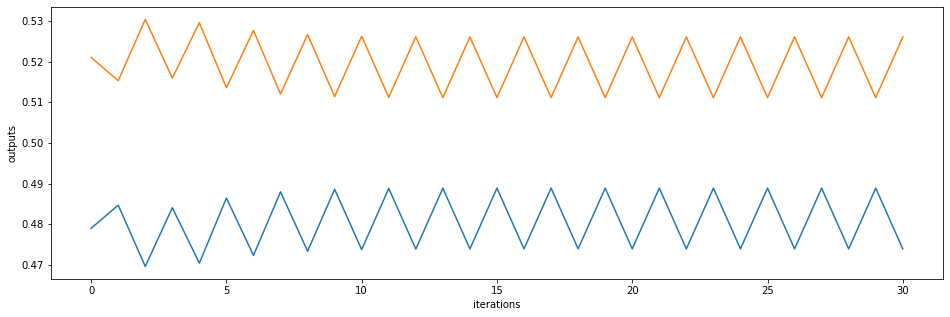

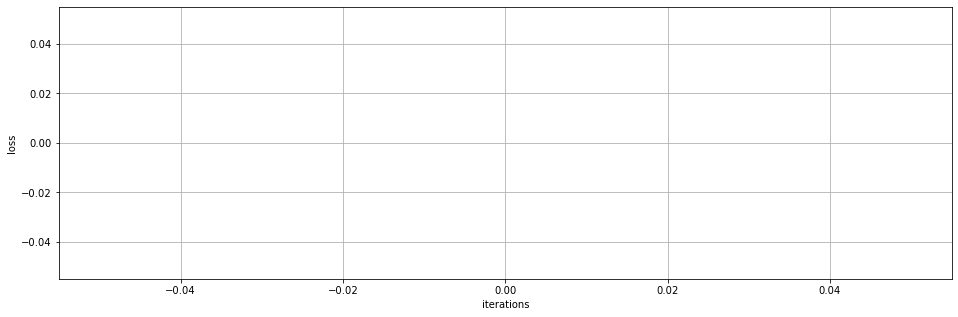

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 1
---------------
epoch 2
---------------
epoch 3
---------------
epoch 4
---------------
epoch 5
---------------
epoch 6
---------------
epoch 7
---------------
epoch 8
---------------
epoch 9
---------------
epoch 10
---------------
epoch 10
learning rate: 0.01994508241070313
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25019859]
 [0.25019859]]


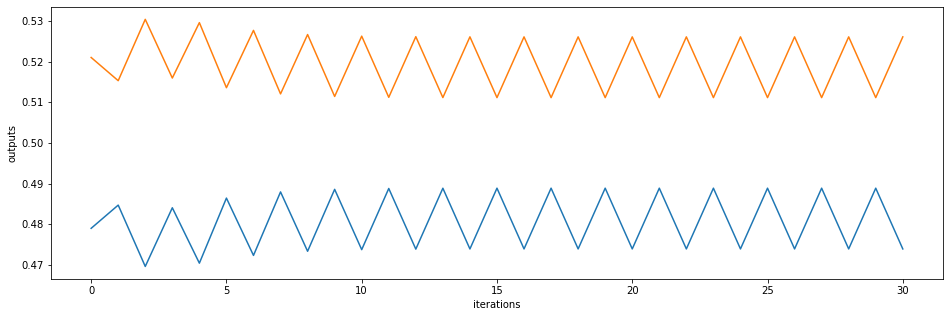

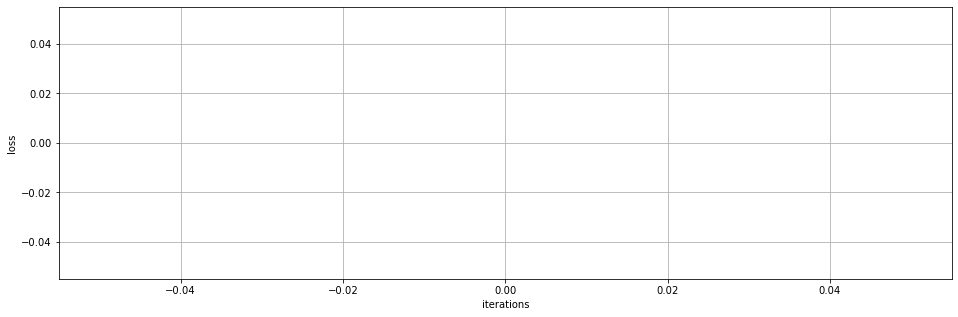

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 11
---------------
epoch 12
---------------
epoch 13
---------------
epoch 14
---------------
epoch 15
---------------
epoch 16
---------------
epoch 17
---------------
epoch 18
---------------
epoch 19
---------------
epoch 20
---------------
epoch 20
learning rate: 0.019895288197391593
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25019889]
 [0.25019889]]


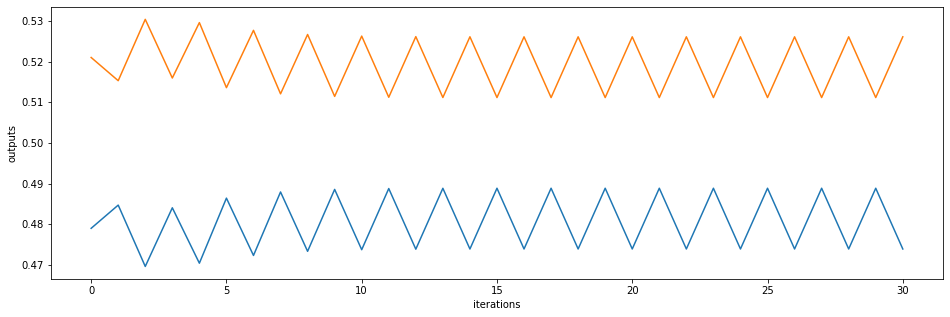

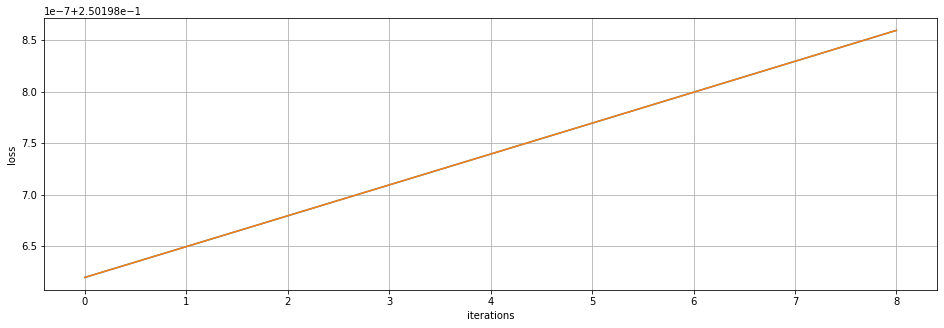

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 21
---------------
epoch 22
---------------
epoch 23
---------------
epoch 24
---------------
epoch 25
---------------
epoch 26
---------------
epoch 27
---------------
epoch 28
---------------
epoch 29
---------------
epoch 30
---------------
epoch 30
learning rate: 0.019845618298616752
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25019919]
 [0.25019919]]


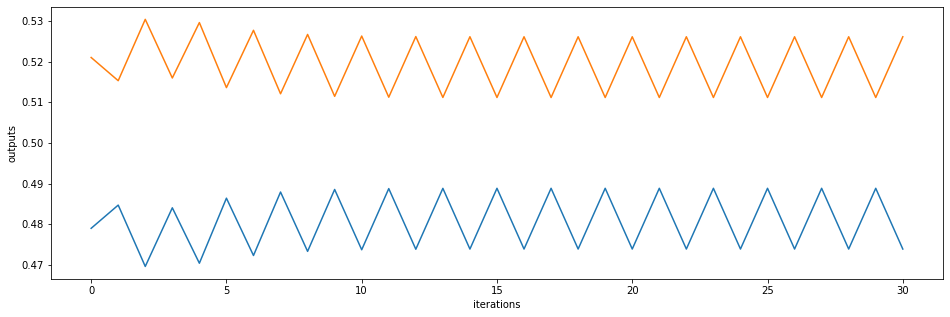

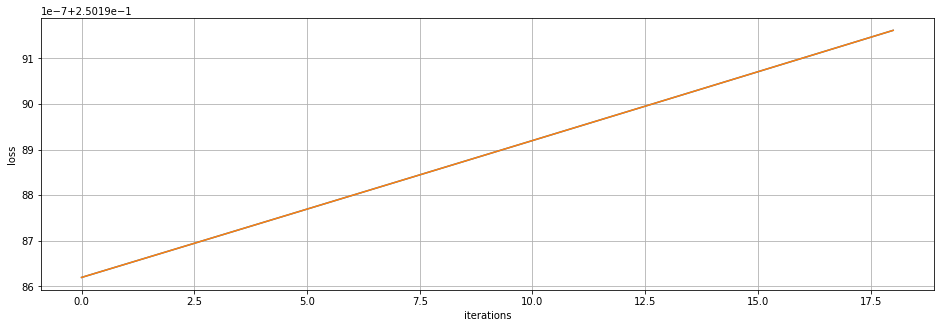

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 31
---------------
epoch 32
---------------
epoch 33
---------------
epoch 34
---------------
epoch 35
---------------
epoch 36
---------------
epoch 37
---------------
epoch 38
---------------
epoch 39
---------------
epoch 40
---------------
epoch 40
learning rate: 0.019796072404019167
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2501995]
 [0.2501995]]


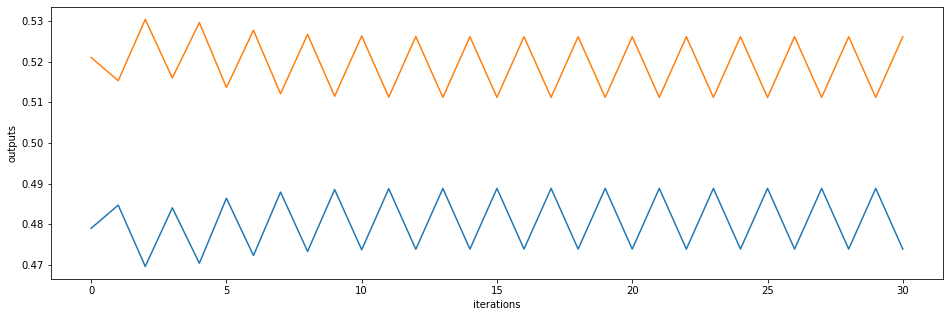

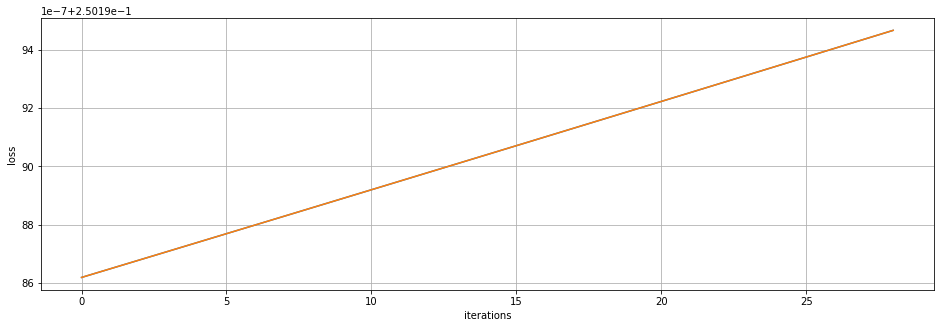

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 41
---------------
epoch 42
---------------
epoch 43
---------------
epoch 44
---------------
epoch 45
---------------
epoch 46
---------------
epoch 47
---------------
epoch 48
---------------
epoch 49
---------------
epoch 50
---------------
epoch 50
learning rate: 0.019746650204014244
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2501998]
 [0.2501998]]


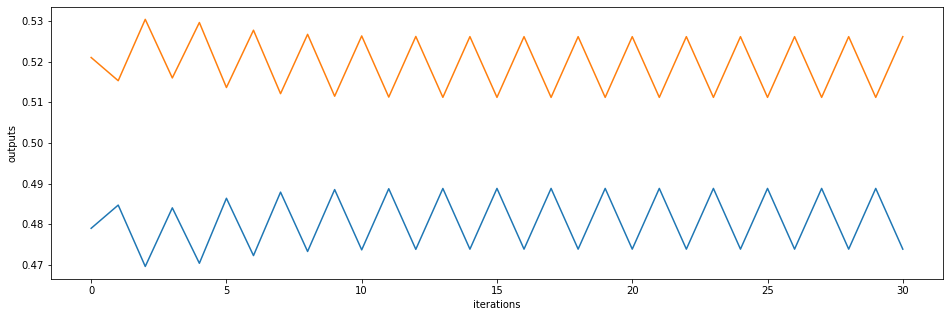

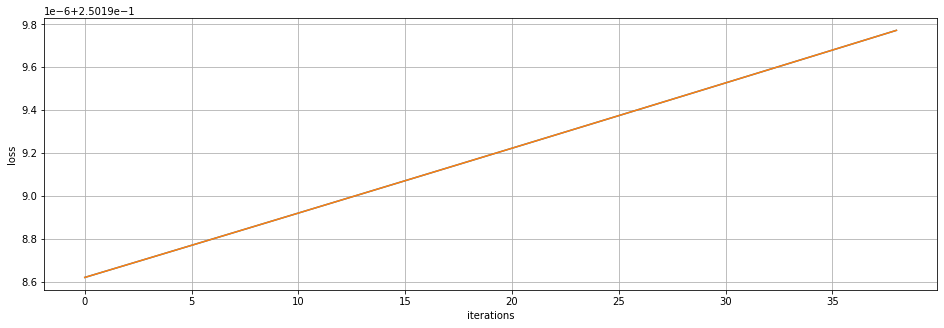

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 51
---------------
epoch 52
---------------
epoch 53
---------------
epoch 54
---------------
epoch 55
---------------
epoch 56
---------------
epoch 57
---------------
epoch 58
---------------
epoch 59
---------------
epoch 60
---------------
epoch 60
learning rate: 0.019697351389790275
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020011]
 [0.25020011]]


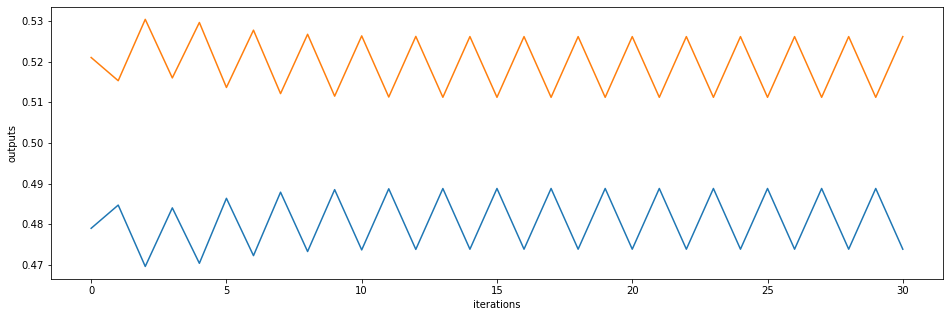

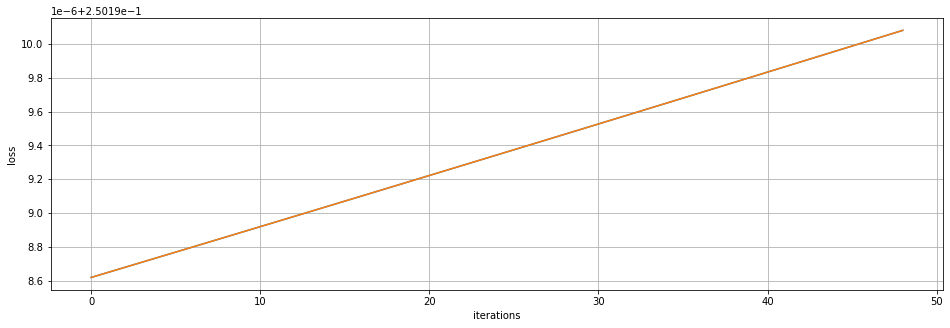

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 61
---------------
epoch 62
---------------
epoch 63
---------------
epoch 64
---------------
epoch 65
---------------
epoch 66
---------------
epoch 67
---------------
epoch 68
---------------
epoch 69
---------------
epoch 70
---------------
epoch 70
learning rate: 0.01964817565330651
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020042]
 [0.25020042]]


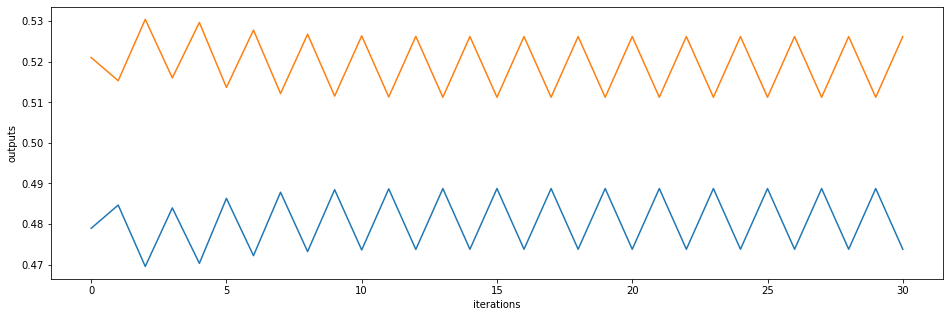

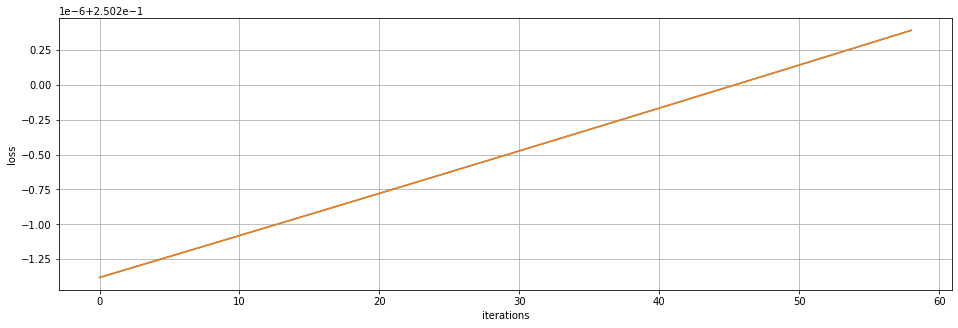

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 71
---------------
epoch 72
---------------
epoch 73
---------------
epoch 74
---------------
epoch 75
---------------
epoch 76
---------------
epoch 77
---------------
epoch 78
---------------
epoch 79
---------------
epoch 80
---------------
epoch 80
learning rate: 0.01959912268729127
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020073]
 [0.25020073]]


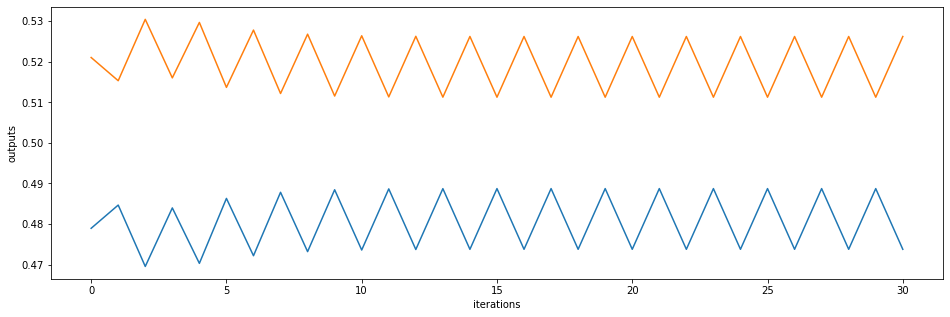

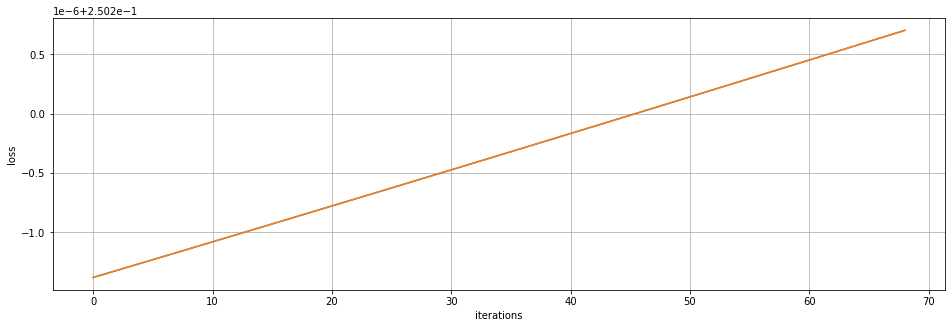

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 81
---------------
epoch 82
---------------
epoch 83
---------------
epoch 84
---------------
epoch 85
---------------
epoch 86
---------------
epoch 87
---------------
epoch 88
---------------
epoch 89
---------------
epoch 90
---------------
epoch 90
learning rate: 0.01955019218523998
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020105]
 [0.25020105]]


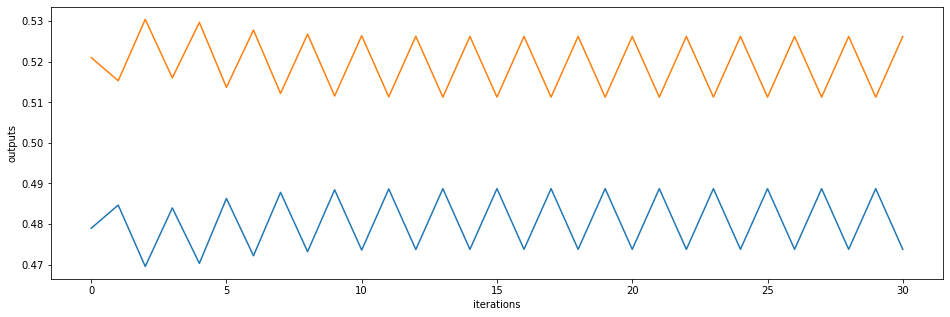

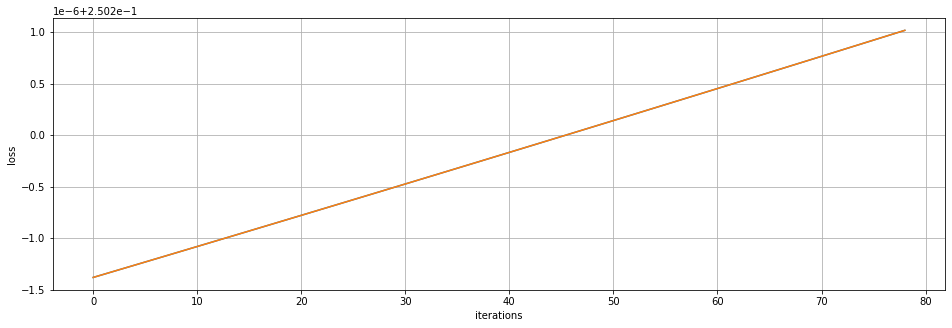

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 91
---------------
epoch 92
---------------
epoch 93
---------------
epoch 94
---------------
epoch 95
---------------
epoch 96
---------------
epoch 97
---------------
epoch 98
---------------
epoch 99
---------------
epoch 100
---------------
epoch 100
learning rate: 0.019501383841413283
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020137]
 [0.25020137]]


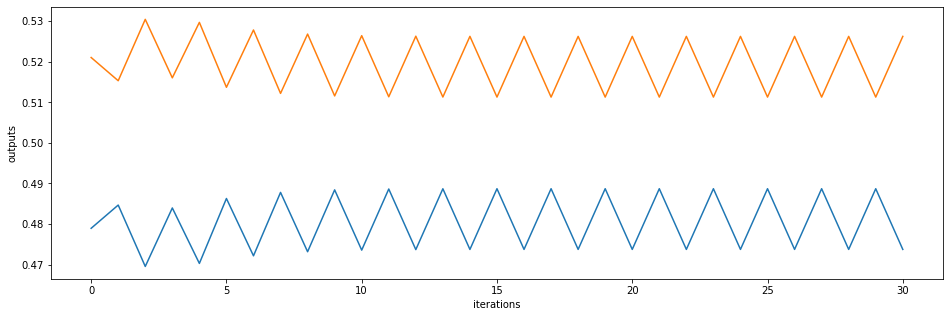

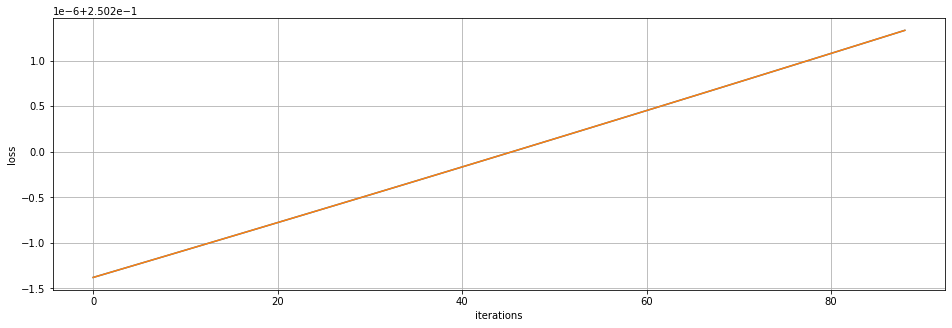

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 101
---------------
epoch 102
---------------
epoch 103
---------------
epoch 104
---------------
epoch 105
---------------
epoch 106
---------------
epoch 107
---------------
epoch 108
---------------
epoch 109
---------------
epoch 110
---------------
epoch 110
learning rate: 0.019452697350835112
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020168]
 [0.25020168]]


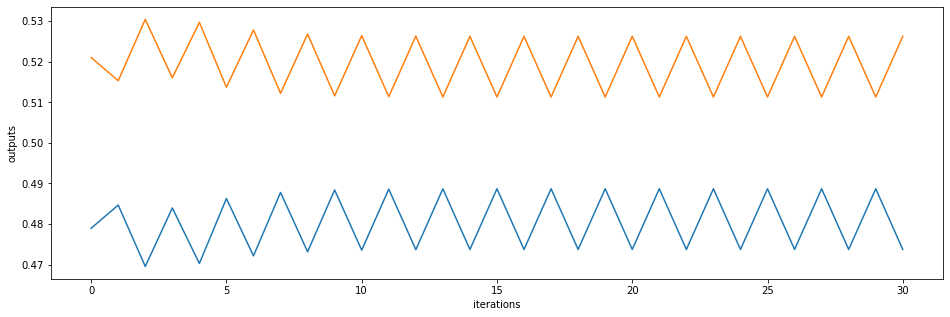

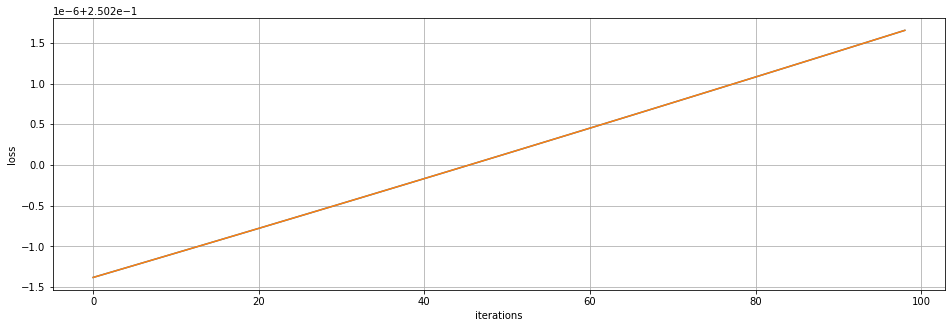

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 111
---------------
epoch 112
---------------
epoch 113
---------------
epoch 114
---------------
epoch 115
---------------
epoch 116
---------------
epoch 117
---------------
epoch 118
---------------
epoch 119
---------------
epoch 120
---------------
epoch 120
learning rate: 0.0194041324092908
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020201]
 [0.25020201]]


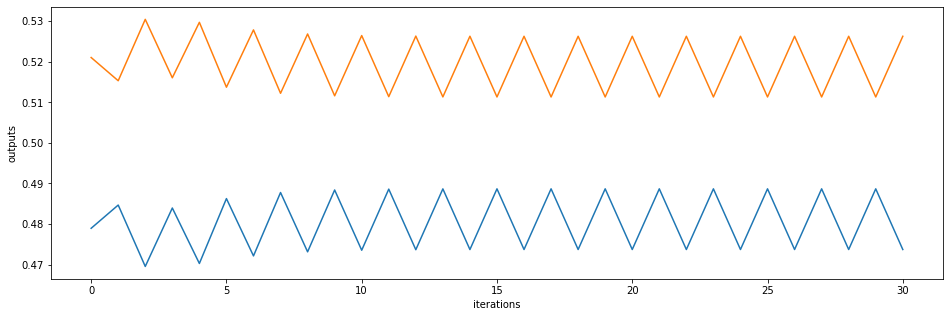

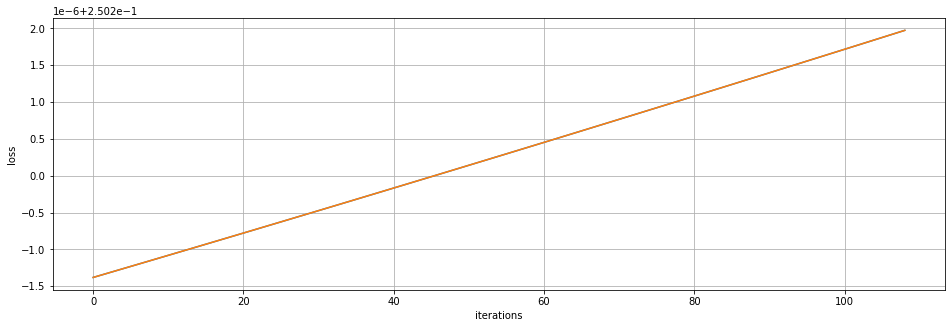

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 121
---------------
epoch 122
---------------
epoch 123
---------------
epoch 124
---------------
epoch 125
---------------
epoch 126
---------------
epoch 127
---------------
epoch 128
---------------
epoch 129
---------------
epoch 130
---------------
epoch 130
learning rate: 0.019355688713325166
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020233]
 [0.25020233]]


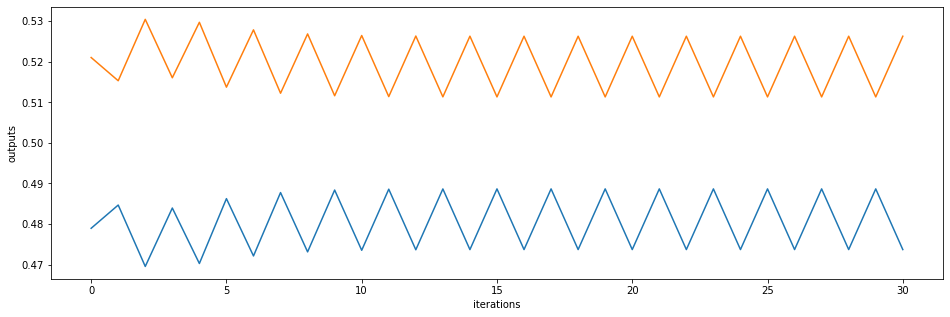

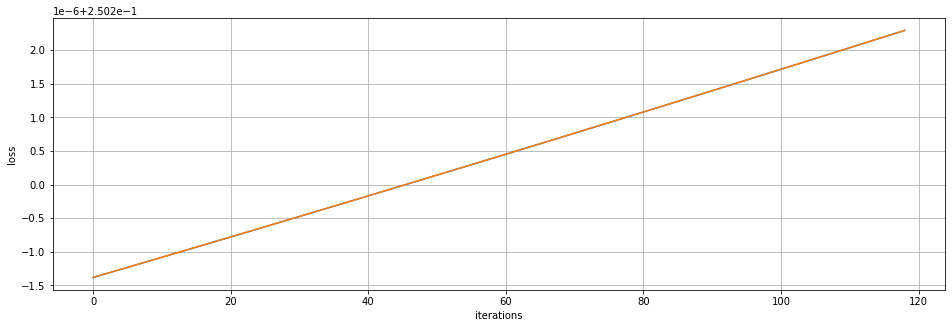

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 131
---------------
epoch 132
---------------
epoch 133
---------------
epoch 134
---------------
epoch 135
---------------
epoch 136
---------------
epoch 137
---------------
epoch 138
---------------
epoch 139
---------------
epoch 140
---------------
epoch 140
learning rate: 0.01930736596024063
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020265]
 [0.25020265]]


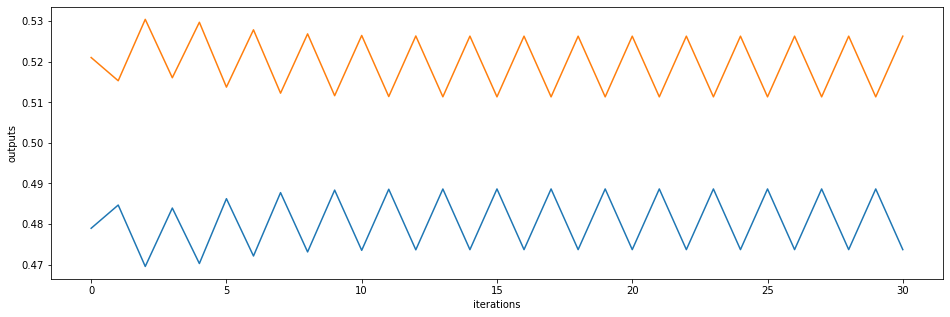

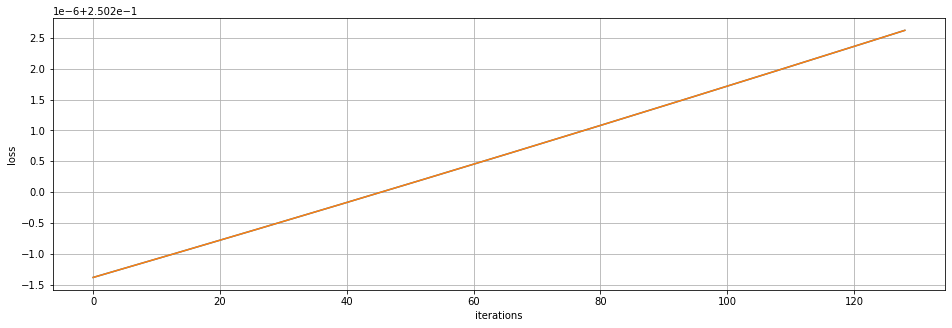

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 141
---------------
epoch 142
---------------
epoch 143
---------------
epoch 144
---------------
epoch 145
---------------
epoch 146
---------------
epoch 147
---------------
epoch 148
---------------
epoch 149
---------------
epoch 150
---------------
epoch 150
learning rate: 0.019259163848095315
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020298]
 [0.25020298]]


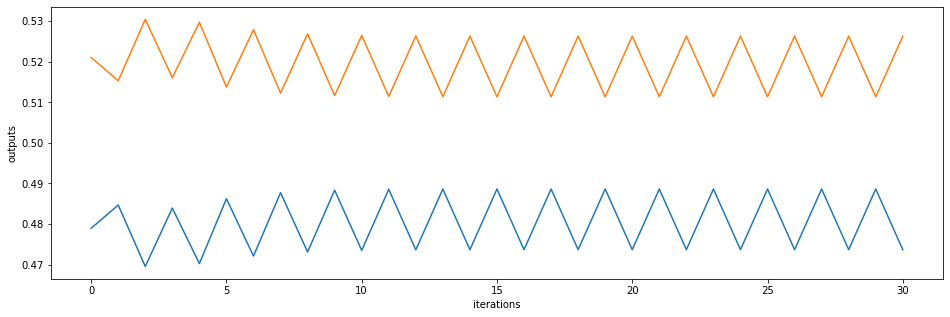

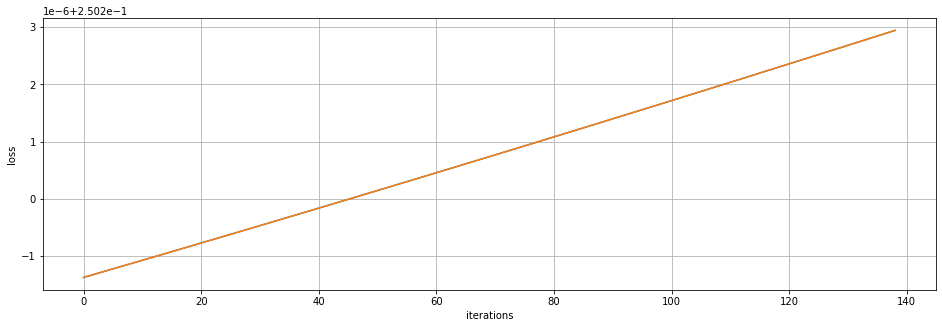

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 151
---------------
epoch 152
---------------
epoch 153
---------------
epoch 154
---------------
epoch 155
---------------
epoch 156
---------------
epoch 157
---------------
epoch 158
---------------
epoch 159
---------------
epoch 160
---------------
epoch 160
learning rate: 0.01921108207570116
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020331]
 [0.25020331]]


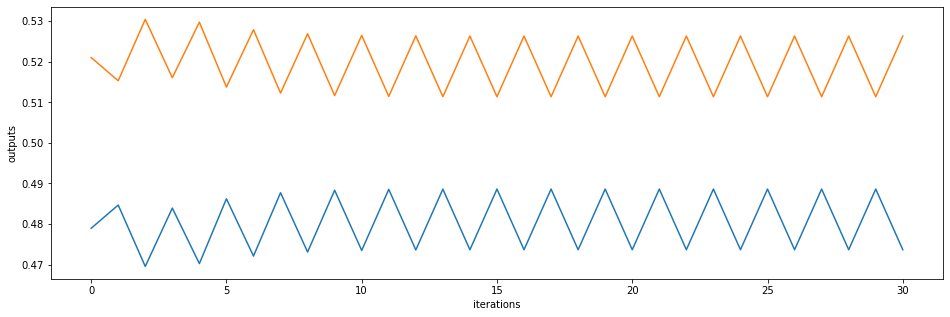

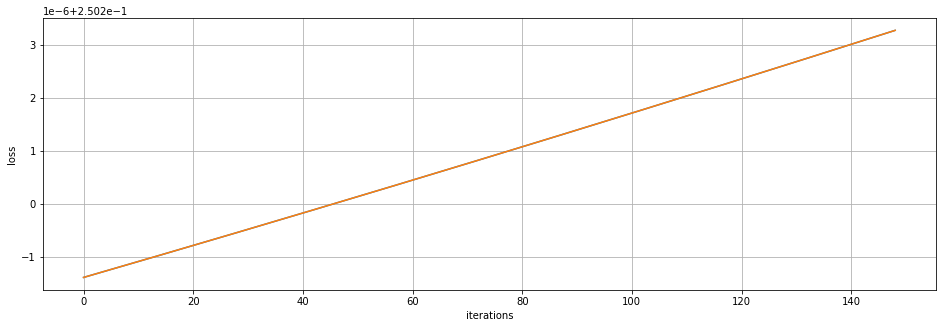

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 161
---------------
epoch 162
---------------
epoch 163
---------------
epoch 164
---------------
epoch 165
---------------
epoch 166
---------------
epoch 167
---------------
epoch 168
---------------
epoch 169
---------------
epoch 170
---------------
epoch 170
learning rate: 0.019163120342622048
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020364]
 [0.25020364]]


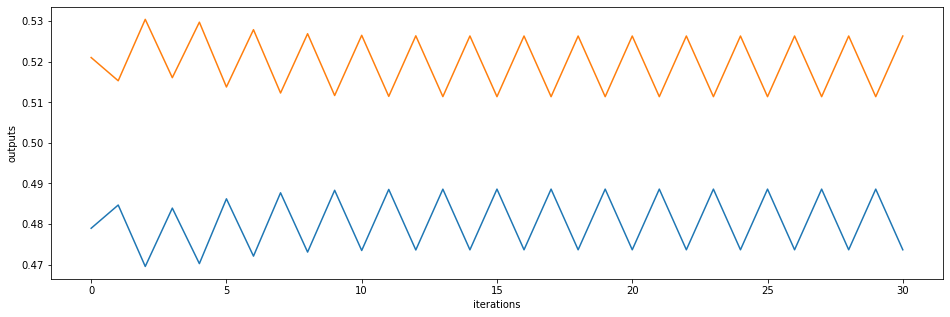

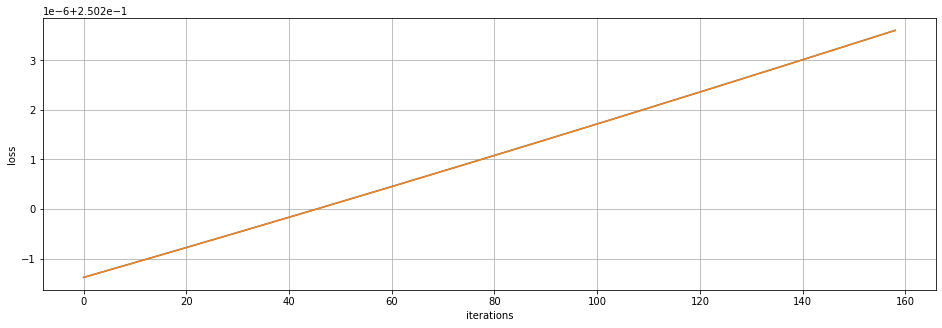

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 171
---------------
epoch 172
---------------
epoch 173
---------------
epoch 174
---------------
epoch 175
---------------
epoch 176
---------------
epoch 177
---------------
epoch 178
---------------
epoch 179
---------------
epoch 180
---------------
epoch 180
learning rate: 0.01911527834917191
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020397]
 [0.25020397]]


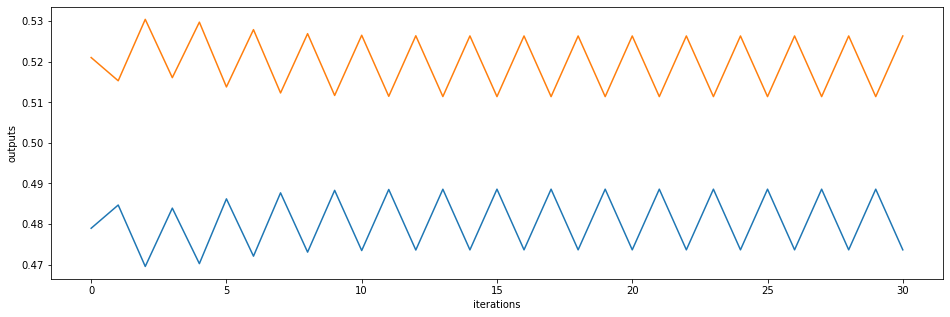

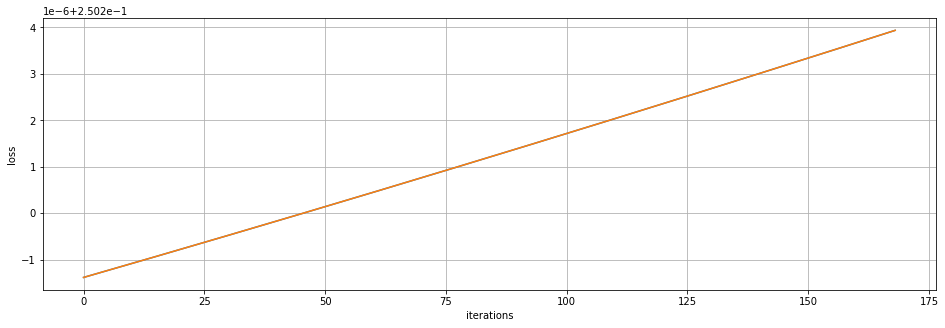

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 181
---------------
epoch 182
---------------
epoch 183
---------------
epoch 184
---------------
epoch 185
---------------
epoch 186
---------------
epoch 187
---------------
epoch 188
---------------
epoch 189
---------------
epoch 190
---------------
epoch 190
learning rate: 0.019067555796412873
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2502043]
 [0.2502043]]


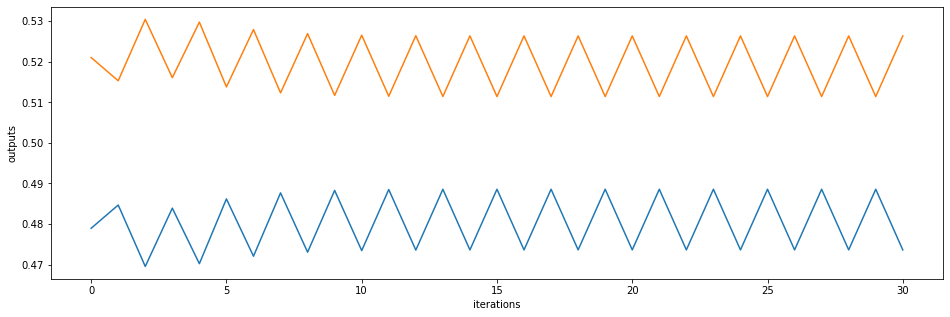

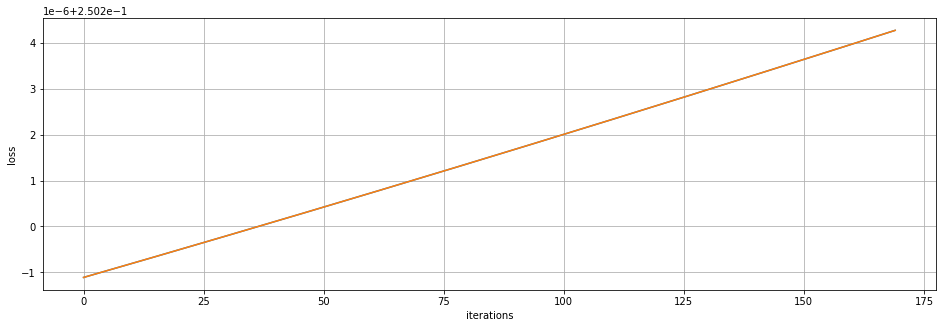

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 191
---------------
epoch 192
---------------
epoch 193
---------------
epoch 194
---------------
epoch 195
---------------
epoch 196
---------------
epoch 197
---------------
epoch 198
---------------
epoch 199
---------------
epoch 200
---------------
epoch 200
learning rate: 0.019019952386153366
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020464]
 [0.25020464]]


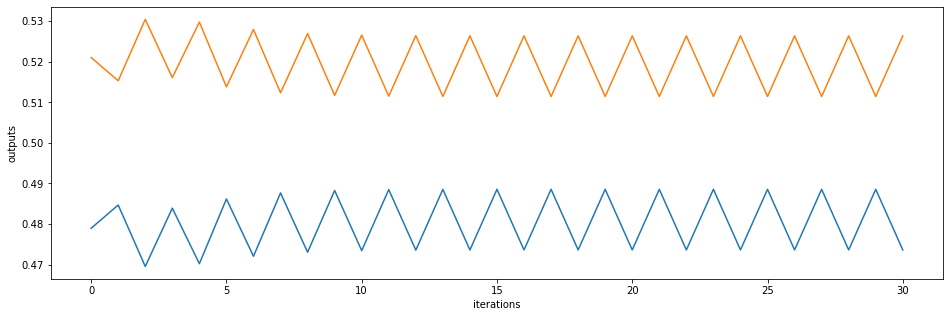

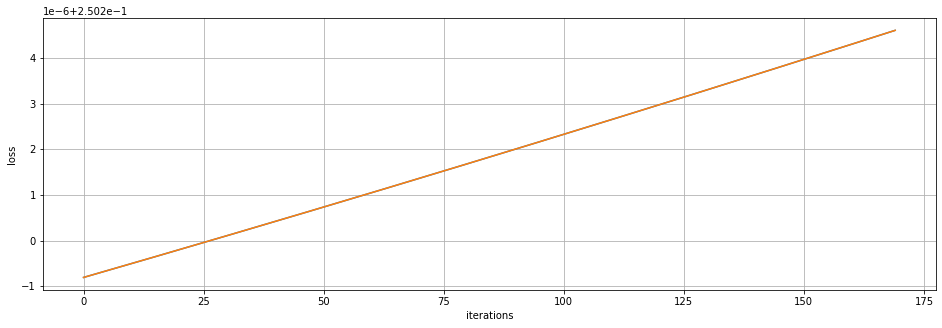

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 201
---------------
epoch 202
---------------
epoch 203
---------------
epoch 204
---------------
epoch 205
---------------
epoch 206
---------------
epoch 207
---------------
epoch 208
---------------
epoch 209
---------------
epoch 210
---------------
epoch 210
learning rate: 0.01897246782094629
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020498]
 [0.25020498]]


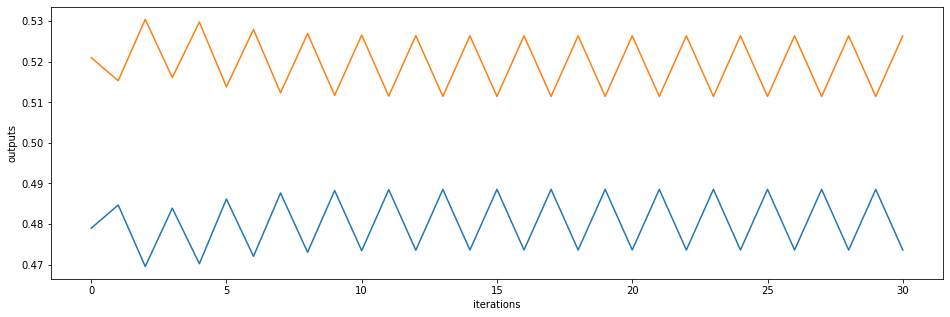

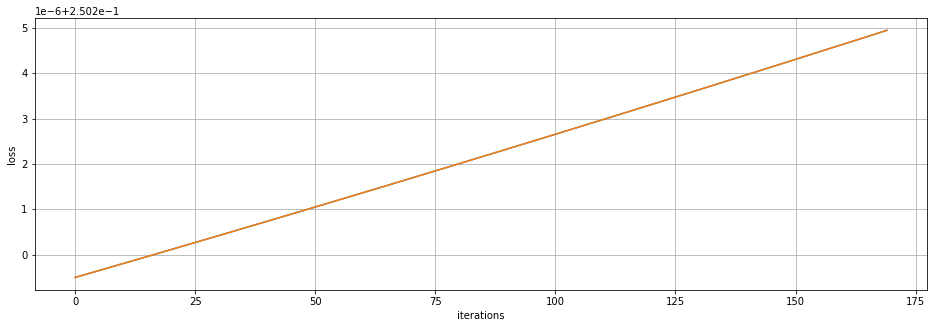

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 211
---------------
epoch 212
---------------
epoch 213
---------------
epoch 214
---------------
epoch 215
---------------
epoch 216
---------------
epoch 217
---------------
epoch 218
---------------
epoch 219
---------------
epoch 220
---------------
epoch 220
learning rate: 0.018925101804087133
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020532]
 [0.25020532]]


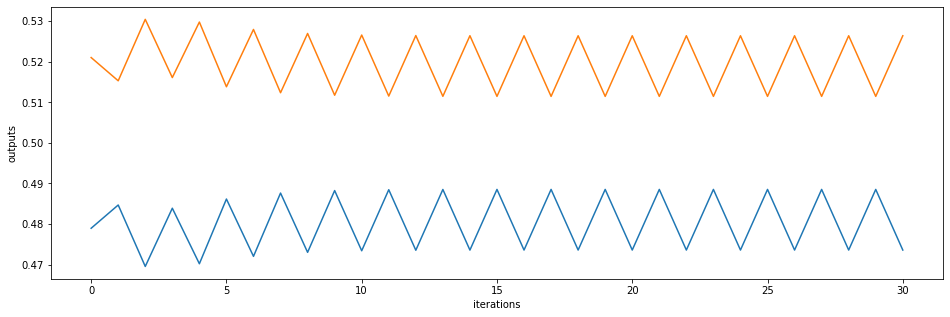

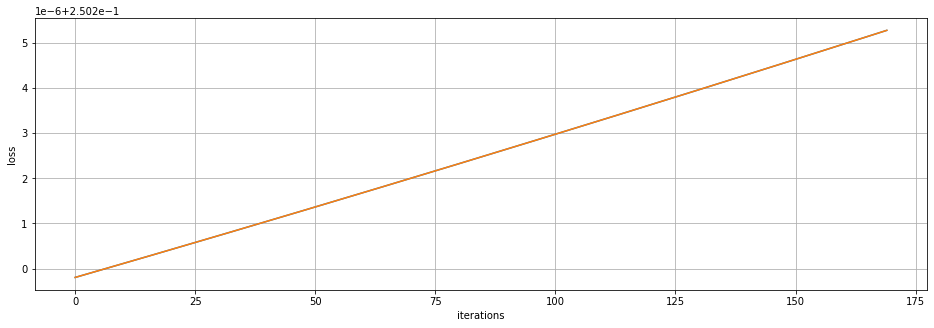

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 221
---------------
epoch 222
---------------
epoch 223
---------------
epoch 224
---------------
epoch 225
---------------
epoch 226
---------------
epoch 227
---------------
epoch 228
---------------
epoch 229
---------------
epoch 230
---------------
epoch 230
learning rate: 0.018877854039612132
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020566]
 [0.25020566]]


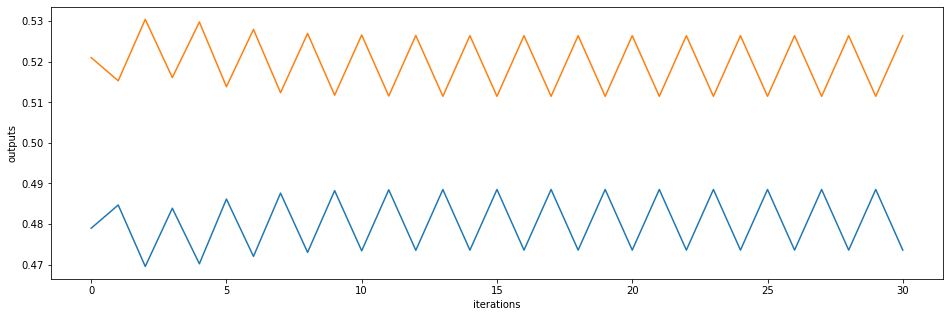

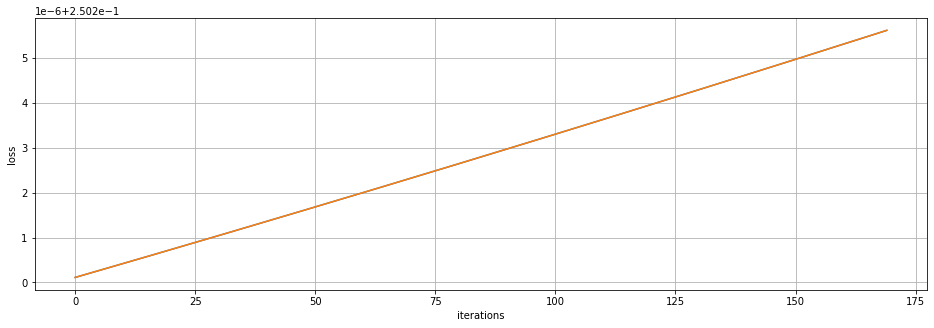

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 231
---------------
epoch 232
---------------
epoch 233
---------------
epoch 234
---------------
epoch 235
---------------
epoch 236
---------------
epoch 237
---------------
epoch 238
---------------
epoch 239
---------------
epoch 240
---------------
epoch 240
learning rate: 0.018830724232296415
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.250206]
 [0.250206]]


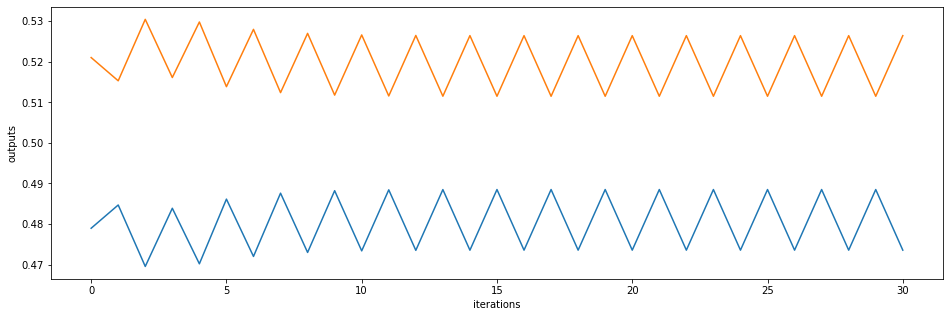

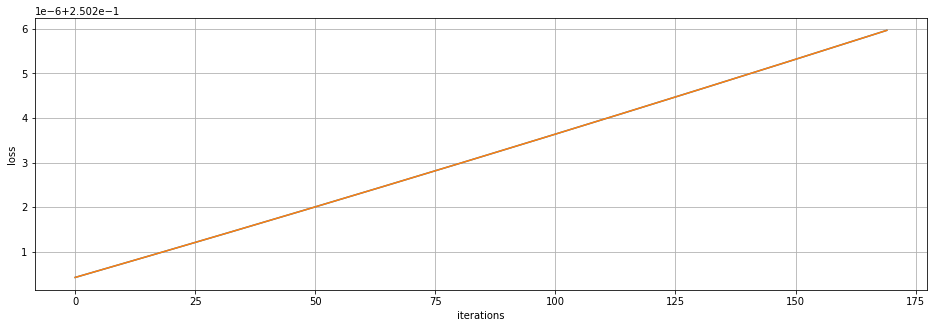

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 241
---------------
epoch 242
---------------
epoch 243
---------------
epoch 244
---------------
epoch 245
---------------
epoch 246
---------------
epoch 247
---------------
epoch 248
---------------
epoch 249
---------------
epoch 250
---------------
epoch 250
learning rate: 0.018783712087652147
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020635]
 [0.25020635]]


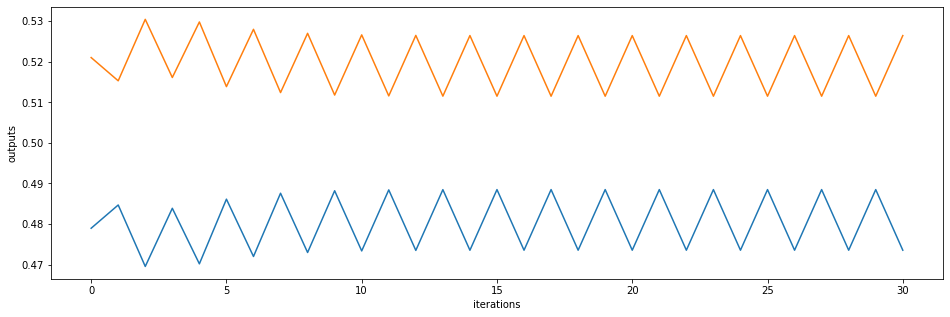

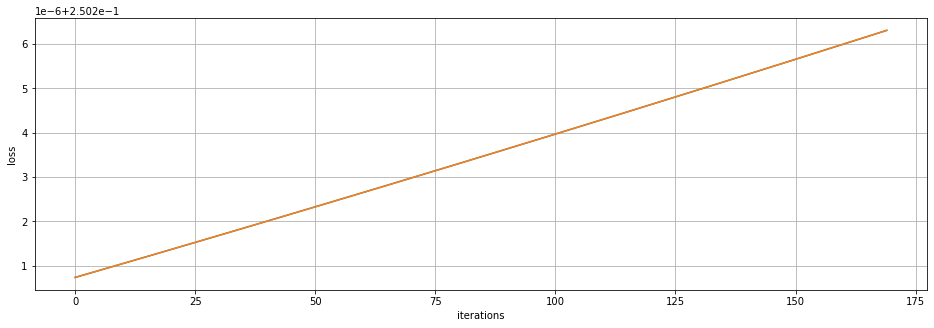

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 251
---------------
epoch 252
---------------
epoch 253
---------------
epoch 254
---------------
epoch 255
---------------
epoch 256
---------------
epoch 257
---------------
epoch 258
---------------
epoch 259
---------------
epoch 260
---------------
epoch 260
learning rate: 0.018736817311926716
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020669]
 [0.25020669]]


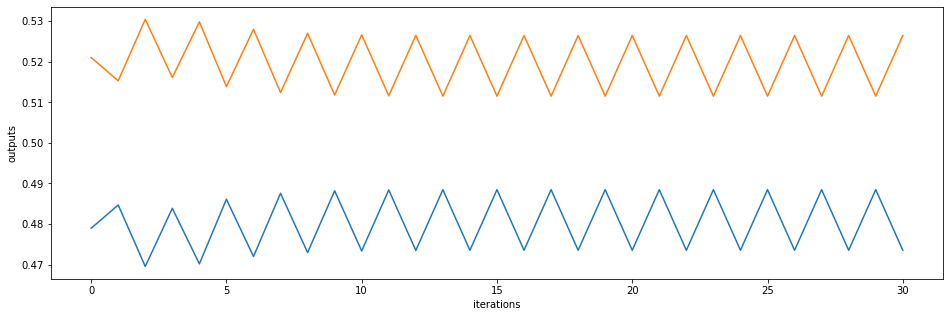

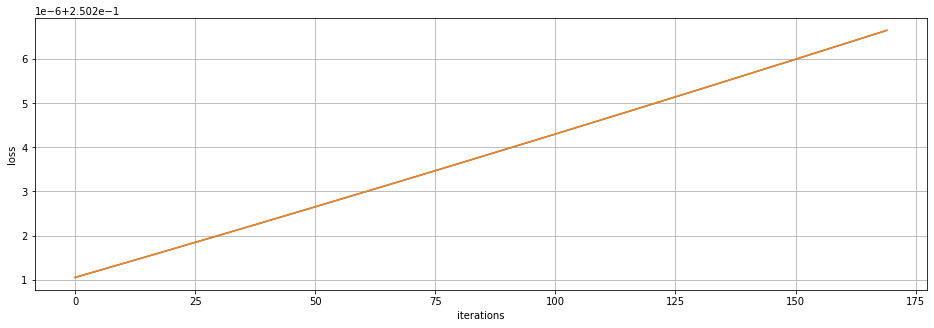

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 261
---------------
epoch 262
---------------
epoch 263
---------------
epoch 264
---------------
epoch 265
---------------
epoch 266
---------------
epoch 267
---------------
epoch 268
---------------
epoch 269
---------------
epoch 270
---------------
epoch 270
learning rate: 0.01869003961210088
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020704]
 [0.25020704]]


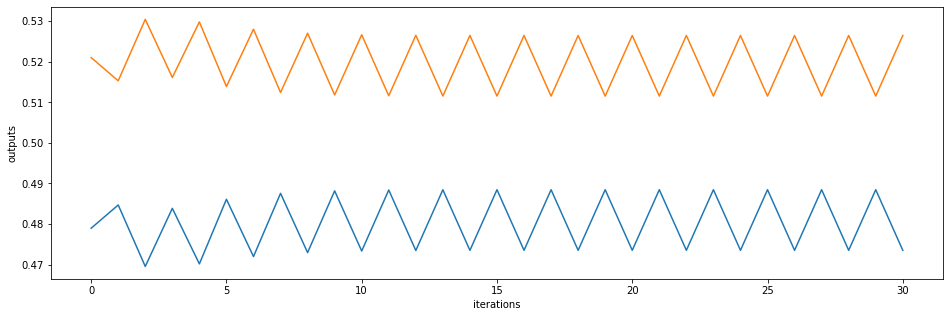

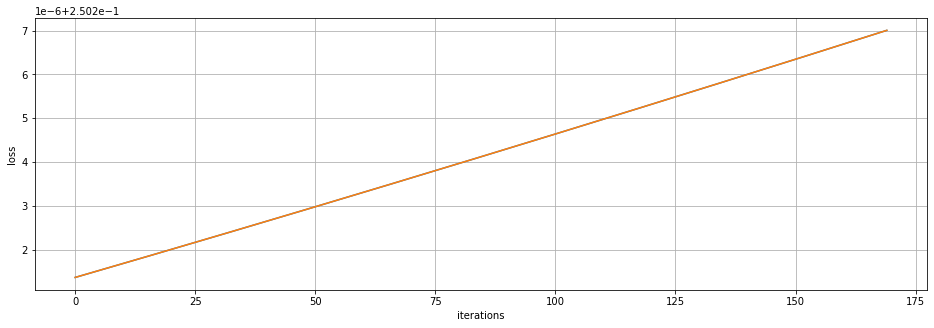

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 271
---------------
epoch 272
---------------
epoch 273
---------------
epoch 274
---------------
epoch 275
---------------
epoch 276
---------------
epoch 277
---------------
epoch 278
---------------
epoch 279
---------------
epoch 280
---------------
epoch 280
learning rate: 0.018643378695886934
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020739]
 [0.25020739]]


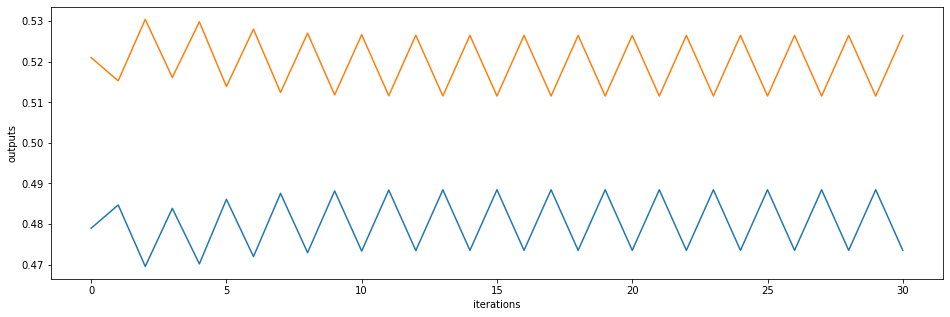

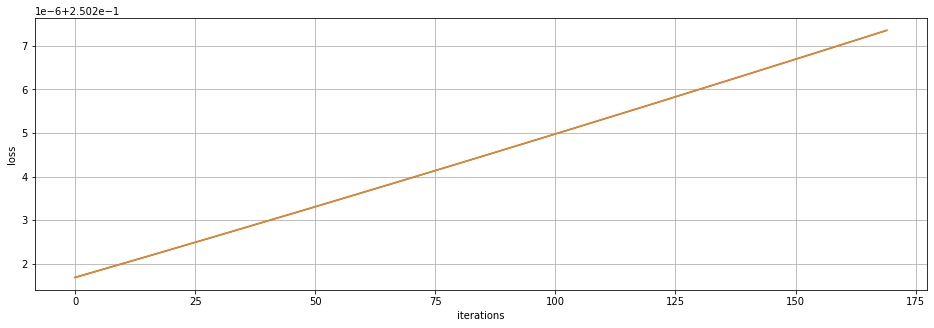

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 281
---------------
epoch 282
---------------
epoch 283
---------------
epoch 284
---------------
epoch 285
---------------
epoch 286
---------------
epoch 287
---------------
epoch 288
---------------
epoch 289
---------------
epoch 290
---------------
epoch 290
learning rate: 0.01859683427172689
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020774]
 [0.25020774]]


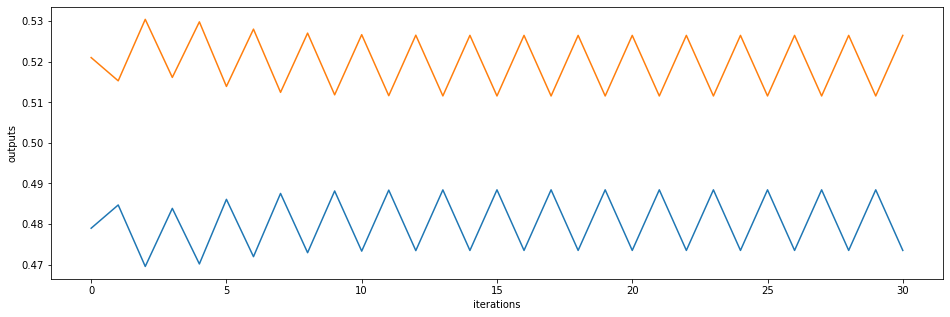

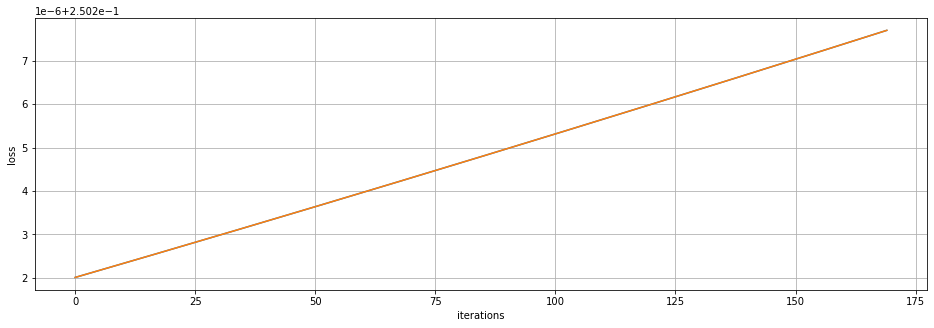

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 291
---------------
epoch 292
---------------
epoch 293
---------------
epoch 294
---------------
epoch 295
---------------
epoch 296
---------------
epoch 297
---------------
epoch 298
---------------
epoch 299
---------------
epoch 300
---------------
epoch 300
learning rate: 0.018550406048790657
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020809]
 [0.25020809]]


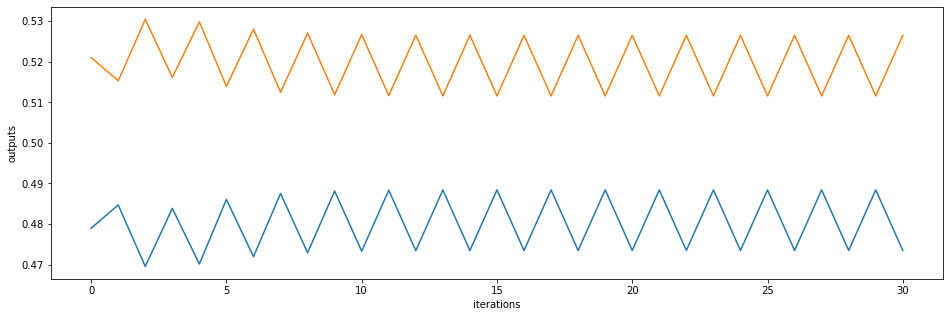

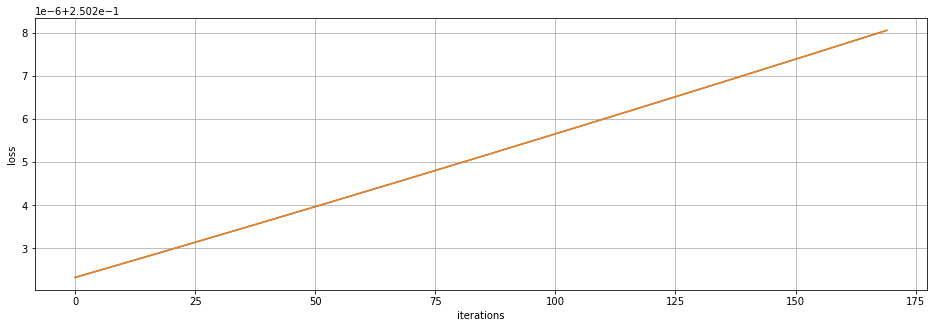

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 301
---------------
epoch 302
---------------
epoch 303
---------------
epoch 304
---------------
epoch 305
---------------
epoch 306
---------------
epoch 307
---------------
epoch 308
---------------
epoch 309
---------------
epoch 310
---------------
epoch 310
learning rate: 0.01850409373697421
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020845]
 [0.25020845]]


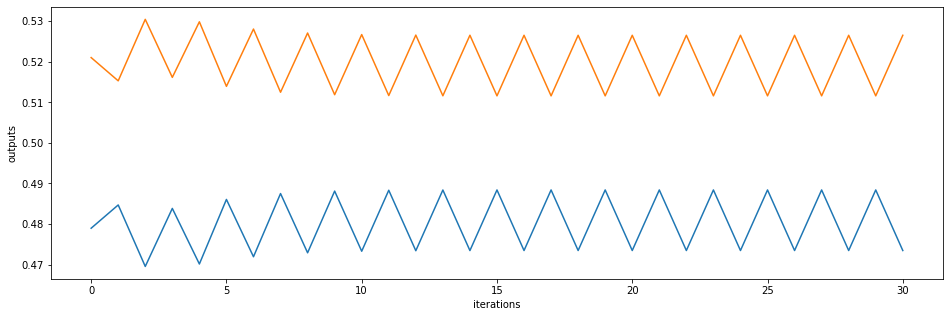

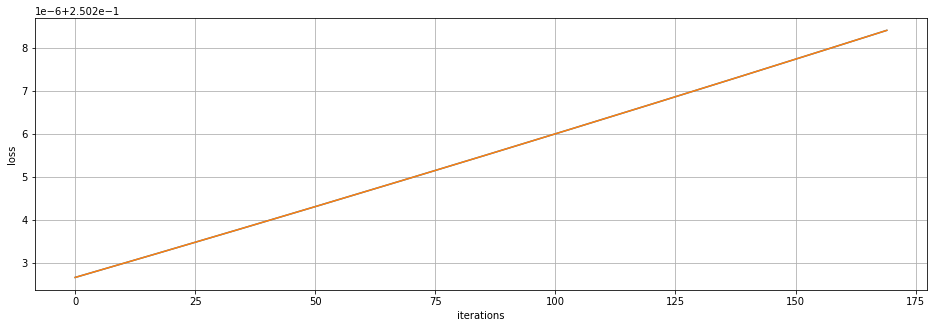

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 311
---------------
epoch 312
---------------
epoch 313
---------------
epoch 314
---------------
epoch 315
---------------
epoch 316
---------------
epoch 317
---------------
epoch 318
---------------
epoch 319
---------------
epoch 320
---------------
epoch 320
learning rate: 0.018457897046897796
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2502088]
 [0.2502088]]


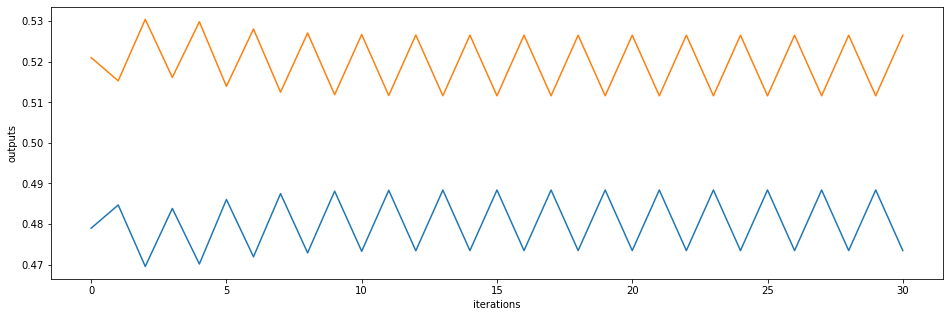

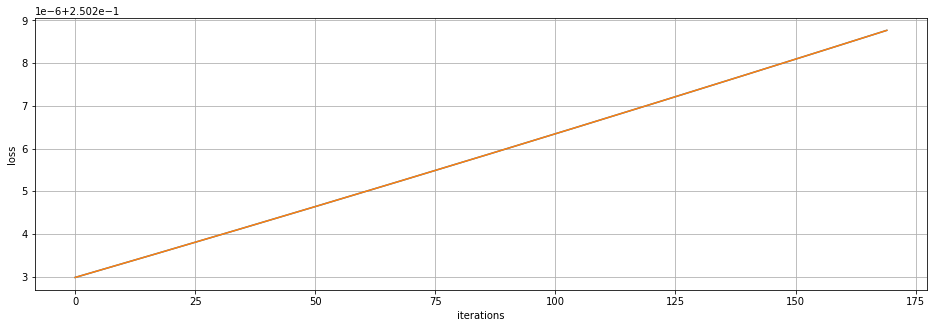

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 321
---------------
epoch 322
---------------
epoch 323
---------------
epoch 324
---------------
epoch 325
---------------
epoch 326
---------------
epoch 327
---------------
epoch 328
---------------
epoch 329
---------------
epoch 330
---------------
epoch 330
learning rate: 0.01841181568990413
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020916]
 [0.25020916]]


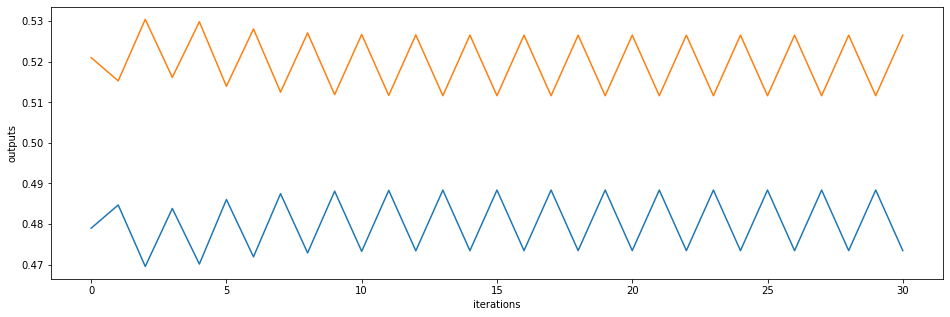

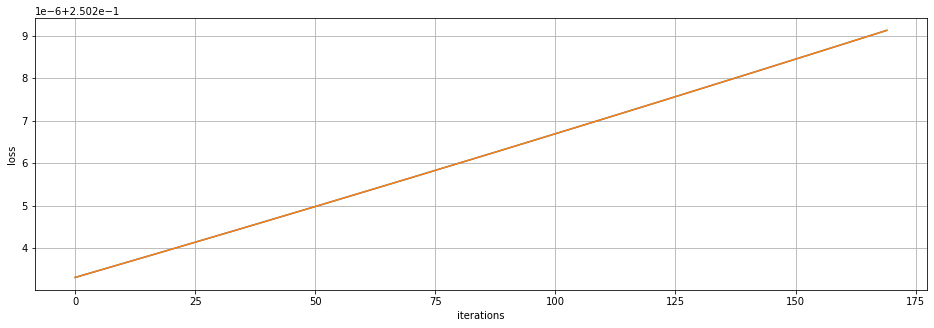

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 331
---------------
epoch 332
---------------
epoch 333
---------------
epoch 334
---------------
epoch 335
---------------
epoch 336
---------------
epoch 337
---------------
epoch 338
---------------
epoch 339
---------------
epoch 340
---------------
epoch 340
learning rate: 0.01836584937805656
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020952]
 [0.25020952]]


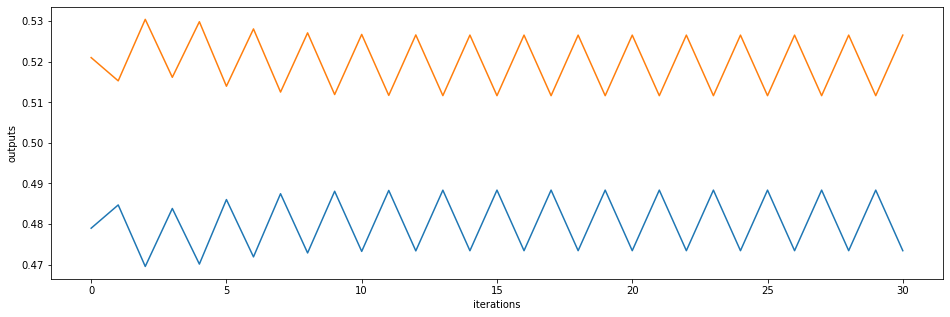

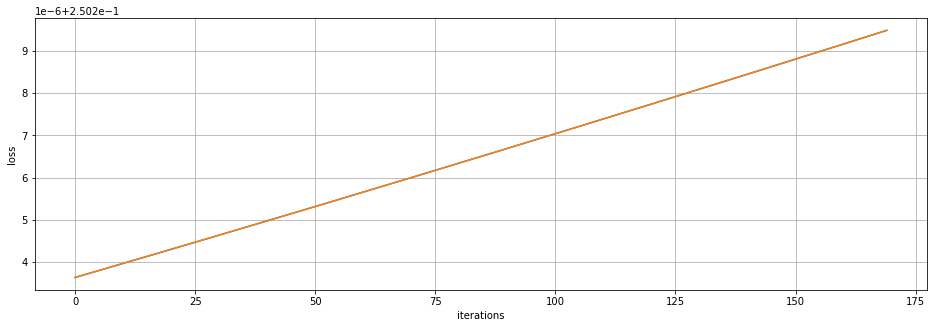

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 341
---------------
epoch 342
---------------
epoch 343
---------------
epoch 344
---------------
epoch 345
---------------
epoch 346
---------------
epoch 347
---------------
epoch 348
---------------
epoch 349
---------------
epoch 350
---------------
epoch 350
learning rate: 0.018319997824137294
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25020988]
 [0.25020988]]


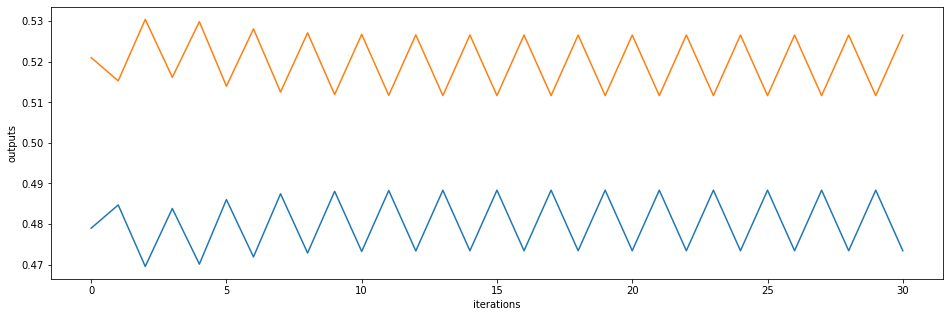

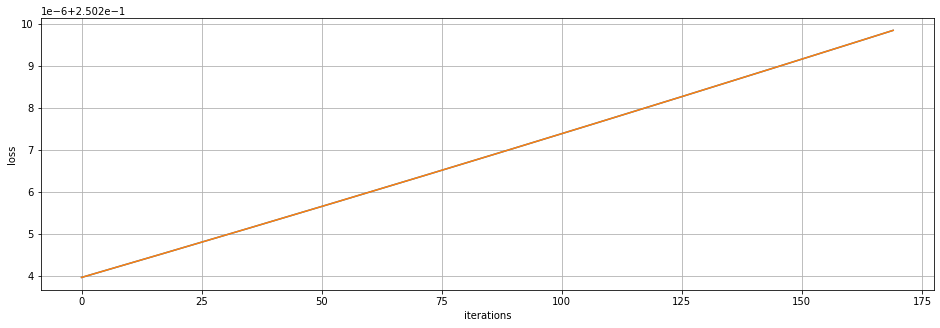

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 351
---------------
epoch 352
---------------
epoch 353
---------------
epoch 354
---------------
epoch 355
---------------
epoch 356
---------------
epoch 357
---------------
epoch 358
---------------
epoch 359
---------------
epoch 360
---------------
epoch 360
learning rate: 0.018274260741645593
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021024]
 [0.25021024]]


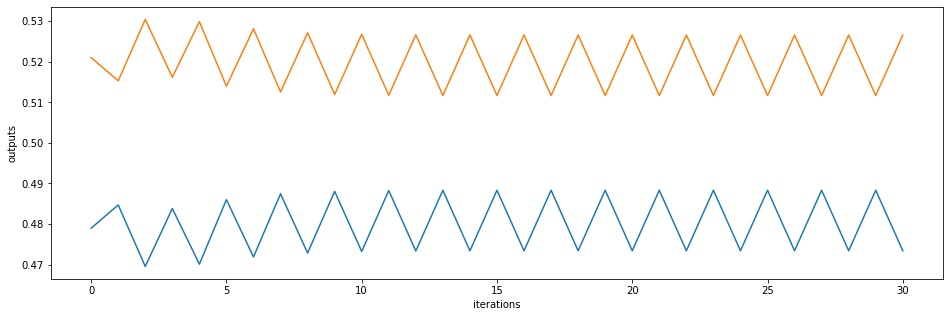

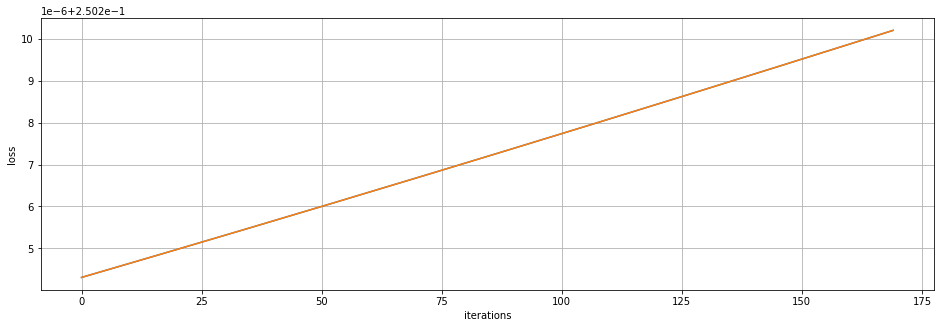

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 361
---------------
epoch 362
---------------
epoch 363
---------------
epoch 364
---------------
epoch 365
---------------
epoch 366
---------------
epoch 367
---------------
epoch 368
---------------
epoch 369
---------------
epoch 370
---------------
epoch 370
learning rate: 0.018228637844795996
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021061]
 [0.25021061]]


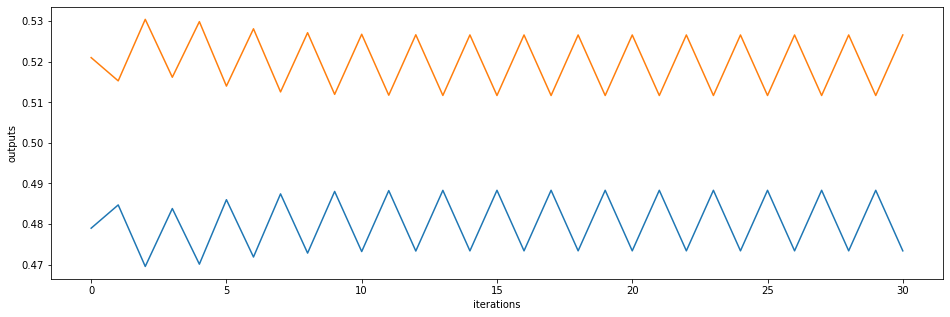

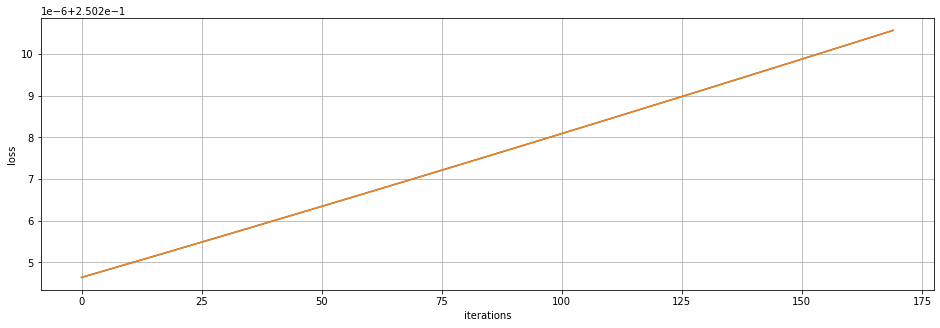

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 371
---------------
epoch 372
---------------
epoch 373
---------------
epoch 374
---------------
epoch 375
---------------
epoch 376
---------------
epoch 377
---------------
epoch 378
---------------
epoch 379
---------------
epoch 380
---------------
epoch 380
learning rate: 0.018183128848516517
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021097]
 [0.25021097]]


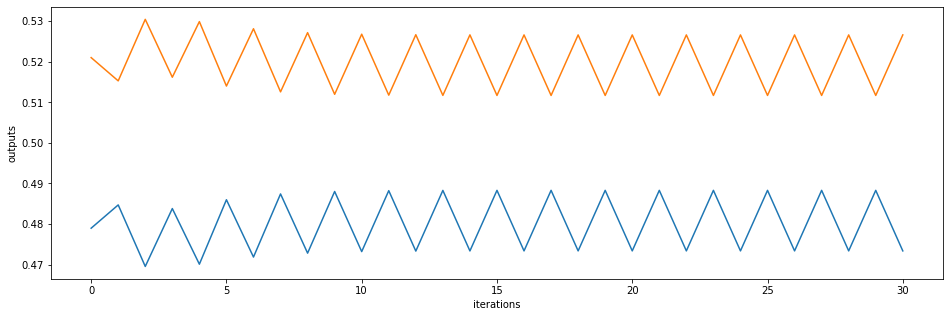

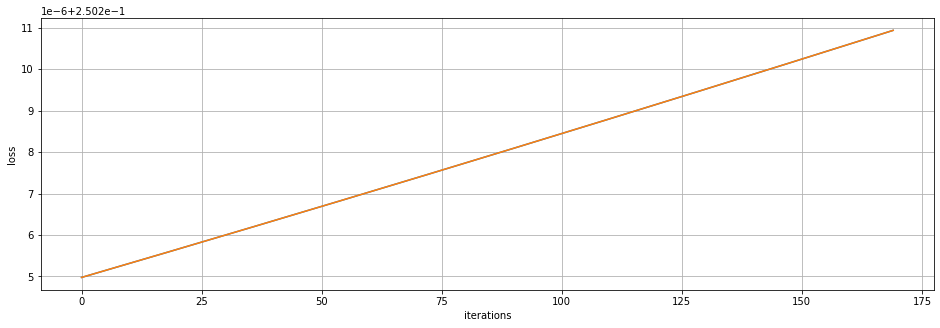

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 381
---------------
epoch 382
---------------
epoch 383
---------------
epoch 384
---------------
epoch 385
---------------
epoch 386
---------------
epoch 387
---------------
epoch 388
---------------
epoch 389
---------------
epoch 390
---------------
epoch 390
learning rate: 0.01813773346844687
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021134]
 [0.25021134]]


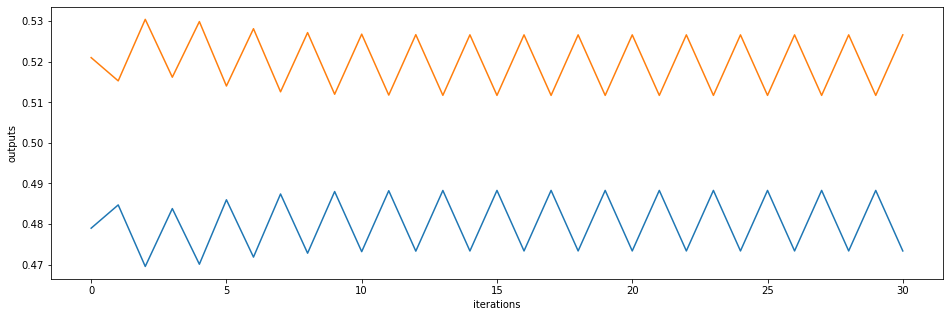

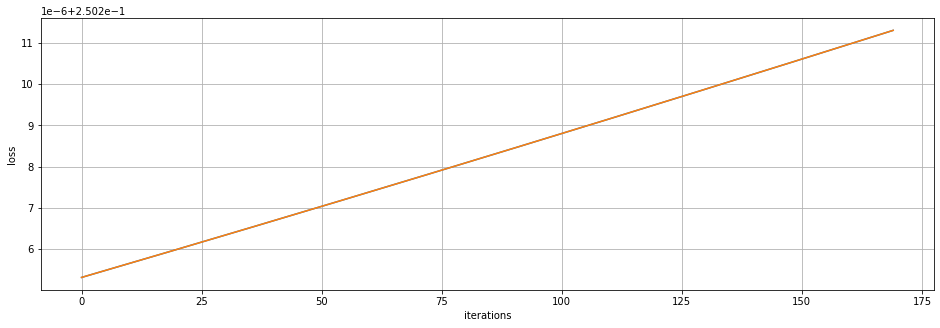

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 391
---------------
epoch 392
---------------
epoch 393
---------------
epoch 394
---------------
epoch 395
---------------
epoch 396
---------------
epoch 397
---------------
epoch 398
---------------
epoch 399
---------------
epoch 400
---------------
epoch 400
learning rate: 0.0180924514209367
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021171]
 [0.25021171]]


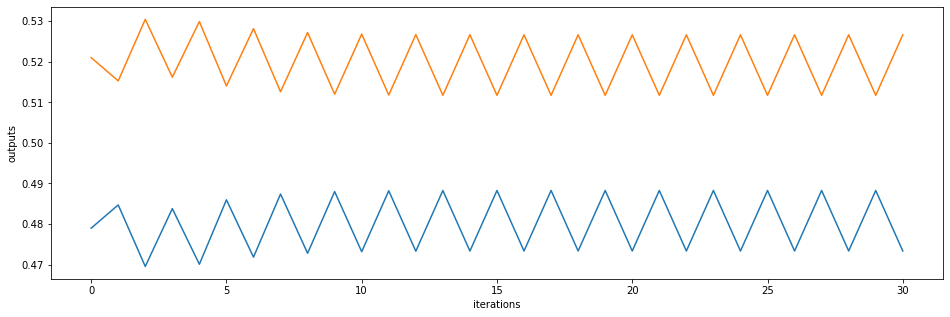

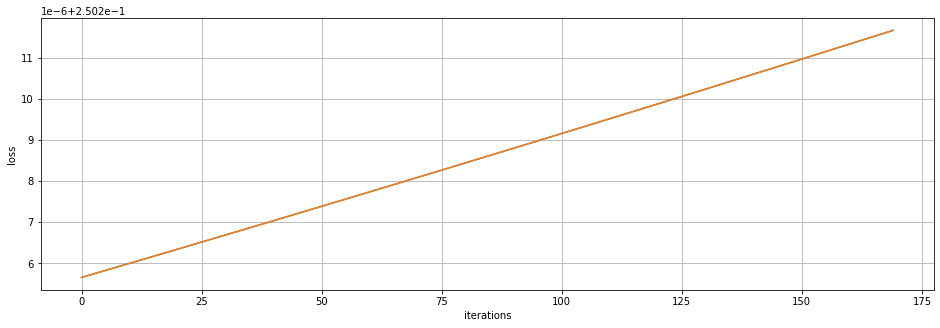

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 401
---------------
epoch 402
---------------
epoch 403
---------------
epoch 404
---------------
epoch 405
---------------
epoch 406
---------------
epoch 407
---------------
epoch 408
---------------
epoch 409
---------------
epoch 410
---------------
epoch 410
learning rate: 0.0180472824230438
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021208]
 [0.25021208]]


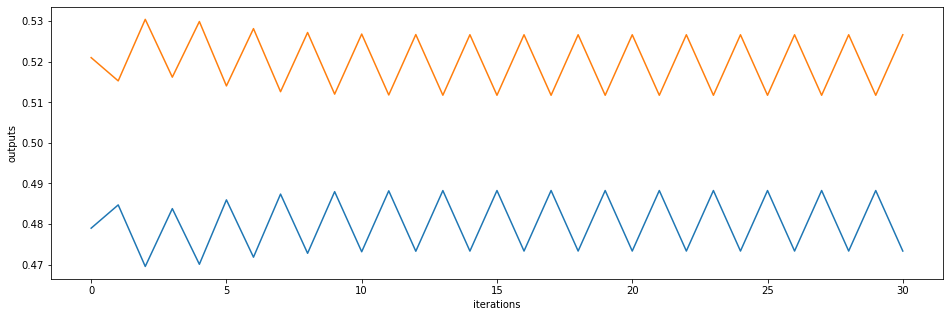

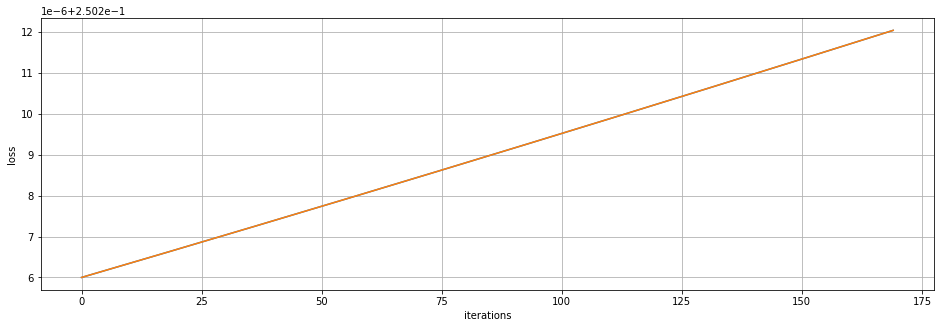

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 411
---------------
epoch 412
---------------
epoch 413
---------------
epoch 414
---------------
epoch 415
---------------
epoch 416
---------------
epoch 417
---------------
epoch 418
---------------
epoch 419
---------------
epoch 420
---------------
epoch 420
learning rate: 0.018002226192532337
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021245]
 [0.25021245]]


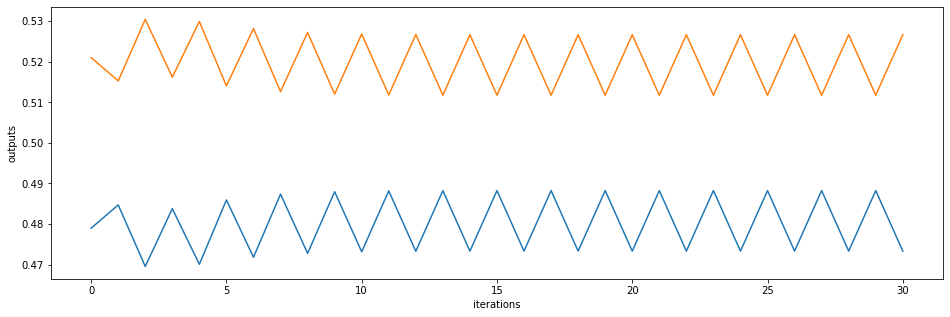

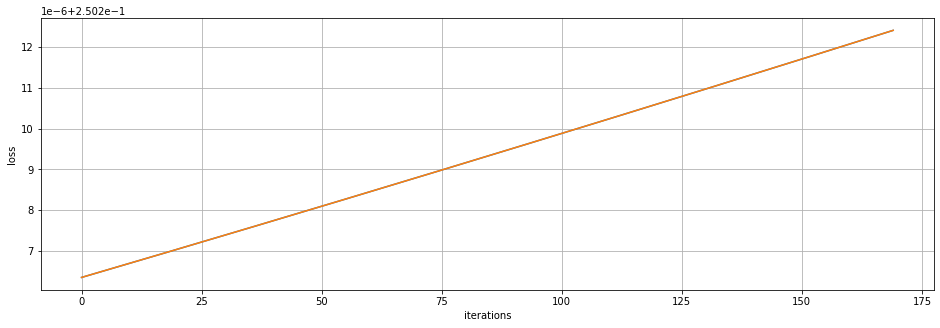

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 421
---------------
epoch 422
---------------
epoch 423
---------------
epoch 424
---------------
epoch 425
---------------
epoch 426
---------------
epoch 427
---------------
epoch 428
---------------
epoch 429
---------------
epoch 430
---------------
epoch 430
learning rate: 0.017957282447871117
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021282]
 [0.25021282]]


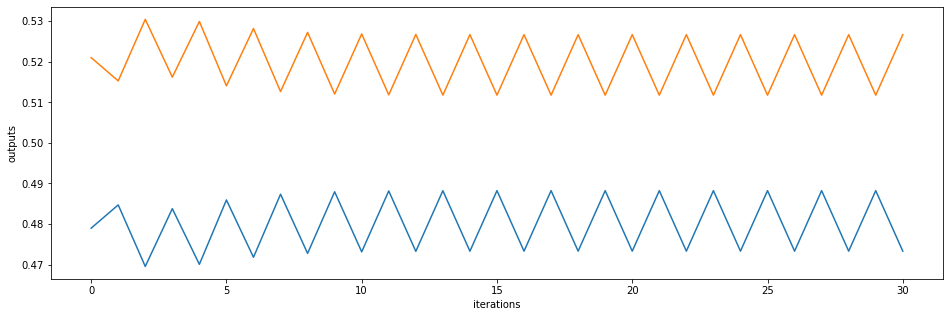

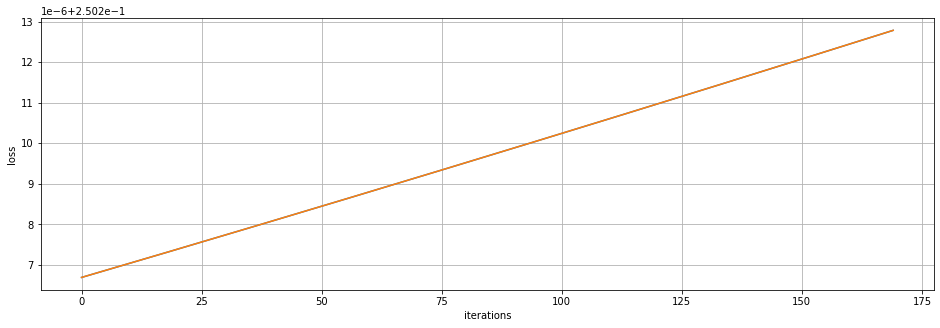

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 431
---------------
epoch 432
---------------
epoch 433
---------------
epoch 434
---------------
epoch 435
---------------
epoch 436
---------------
epoch 437
---------------
epoch 438
---------------
epoch 439
---------------
epoch 440
---------------
epoch 440
learning rate: 0.017912450908231792
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2502132]
 [0.2502132]]


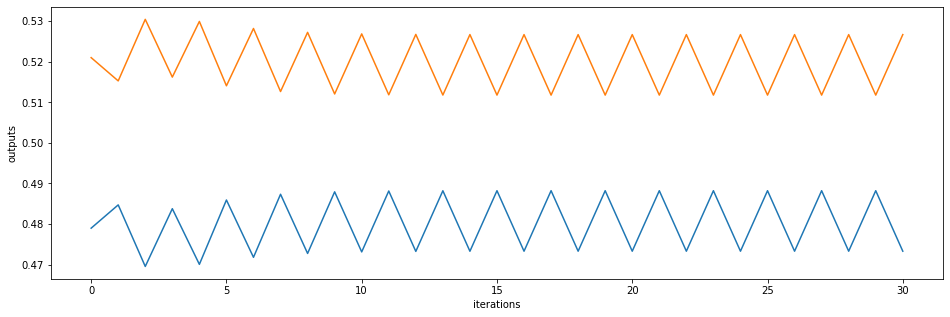

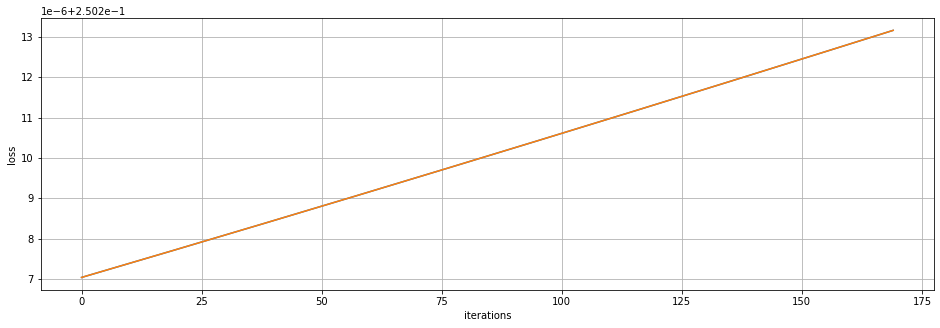

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 441
---------------
epoch 442
---------------
epoch 443
---------------
epoch 444
---------------
epoch 445
---------------
epoch 446
---------------
epoch 447
---------------
epoch 448
---------------
epoch 449
---------------
epoch 450
---------------
epoch 450
learning rate: 0.017867731293487142
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021357]
 [0.25021357]]


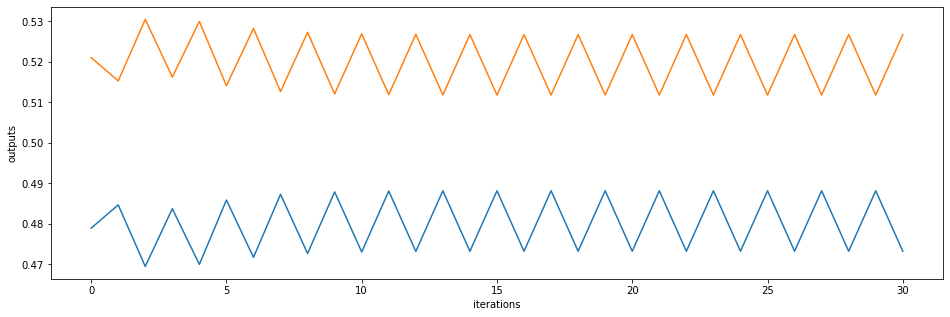

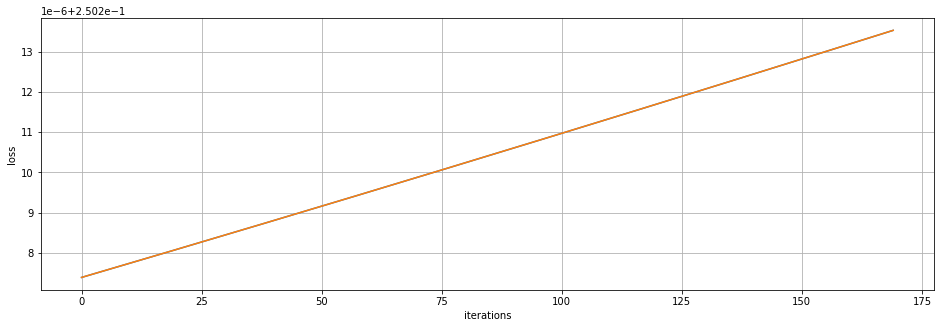

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 451
---------------
epoch 452
---------------
epoch 453
---------------
epoch 454
---------------
epoch 455
---------------
epoch 456
---------------
epoch 457
---------------
epoch 458
---------------
epoch 459
---------------
epoch 460
---------------
epoch 460
learning rate: 0.017823123324209277
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021395]
 [0.25021395]]


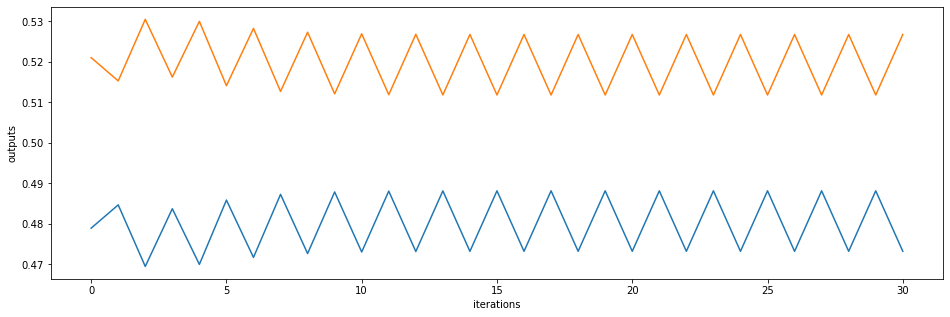

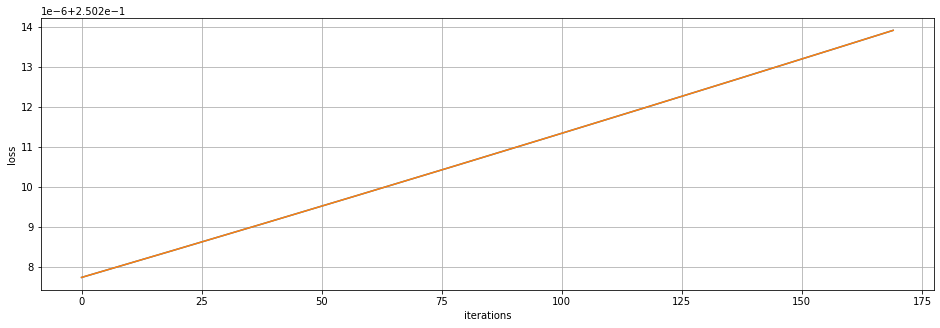

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 461
---------------
epoch 462
---------------
epoch 463
---------------
epoch 464
---------------
epoch 465
---------------
epoch 466
---------------
epoch 467
---------------
epoch 468
---------------
epoch 469
---------------
epoch 470
---------------
epoch 470
learning rate: 0.01777862672166793
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021433]
 [0.25021433]]


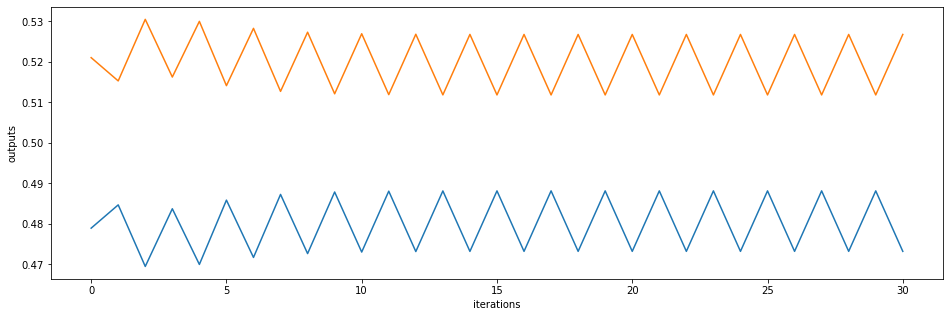

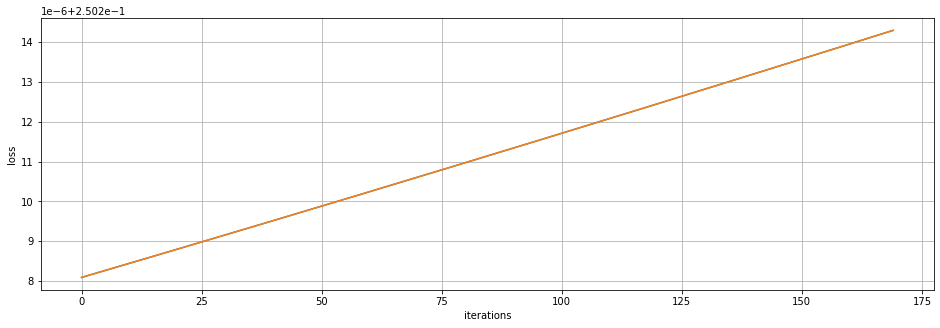

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 471
---------------
epoch 472
---------------
epoch 473
---------------
epoch 474
---------------
epoch 475
---------------
epoch 476
---------------
epoch 477
---------------
epoch 478
---------------
epoch 479
---------------
epoch 480
---------------
epoch 480
learning rate: 0.01773424120782869
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021471]
 [0.25021471]]


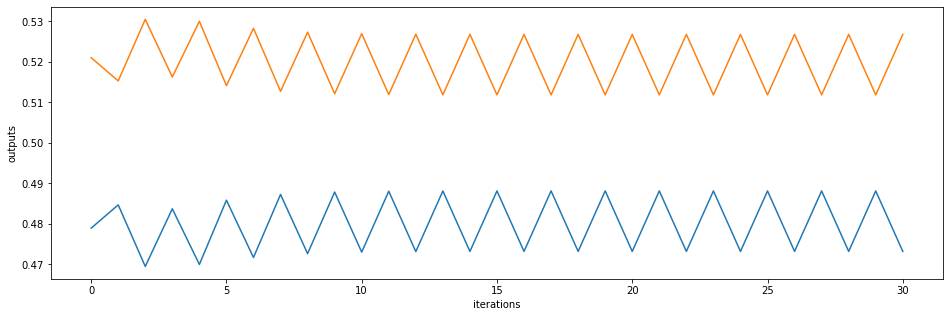

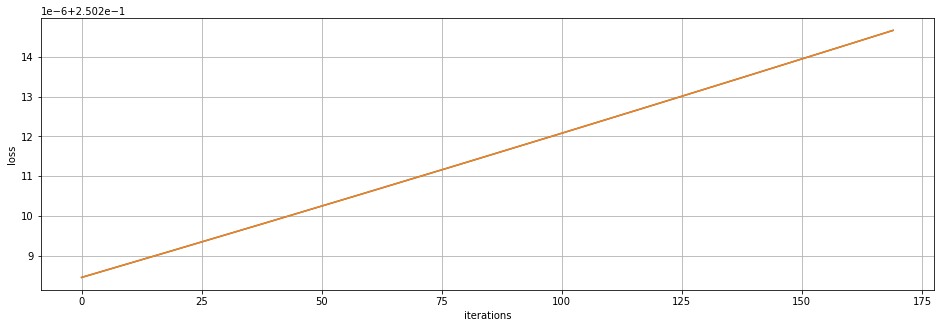

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 481
---------------
epoch 482
---------------
epoch 483
---------------
epoch 484
---------------
epoch 485
---------------
epoch 486
---------------
epoch 487
---------------
epoch 488
---------------
epoch 489
---------------
epoch 490
---------------
epoch 490
learning rate: 0.017689966505351297
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021509]
 [0.25021509]]


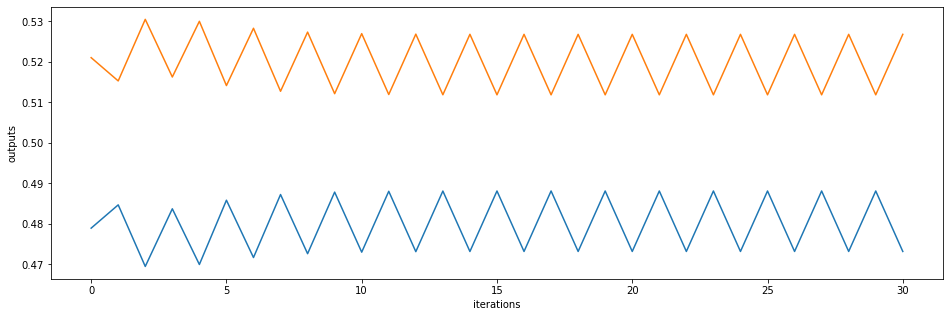

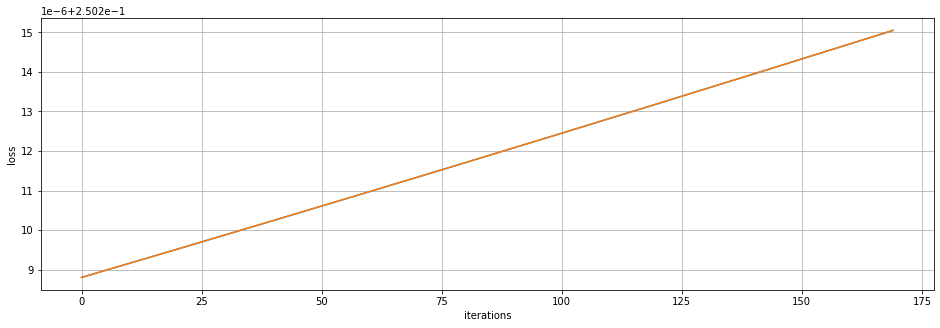

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 491
---------------
epoch 492
---------------
epoch 493
---------------
epoch 494
---------------
epoch 495
---------------
epoch 496
---------------
epoch 497
---------------
epoch 498
---------------
epoch 499
---------------
epoch 500
---------------
epoch 500
learning rate: 0.01764580233758788
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021547]
 [0.25021547]]


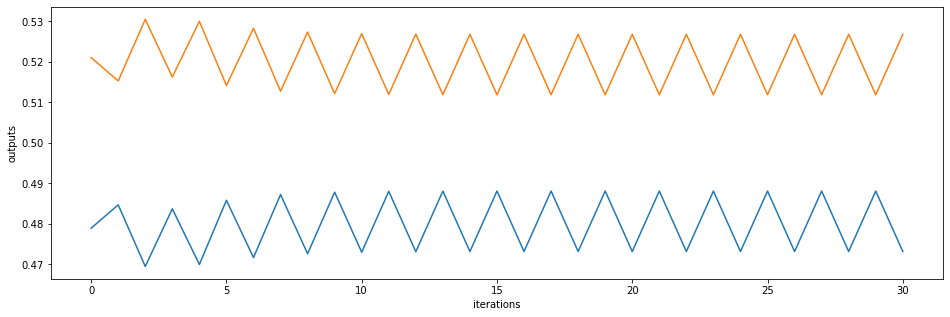

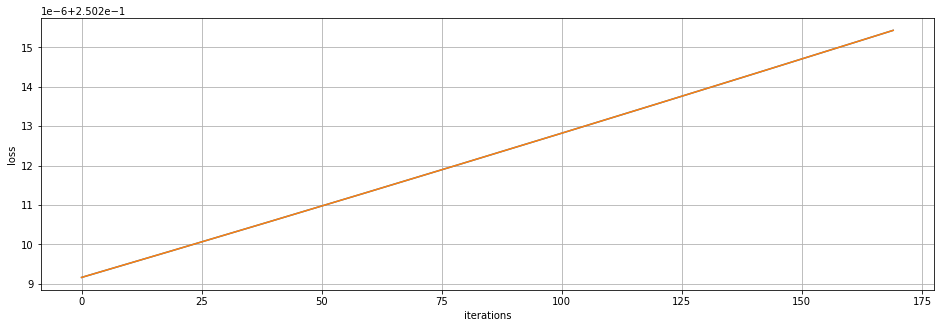

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 501
---------------
epoch 502
---------------
epoch 503
---------------
epoch 504
---------------
epoch 505
---------------
epoch 506
---------------
epoch 507
---------------
epoch 508
---------------
epoch 509
---------------
epoch 510
---------------
epoch 510
learning rate: 0.017601748428581233
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021585]
 [0.25021585]]


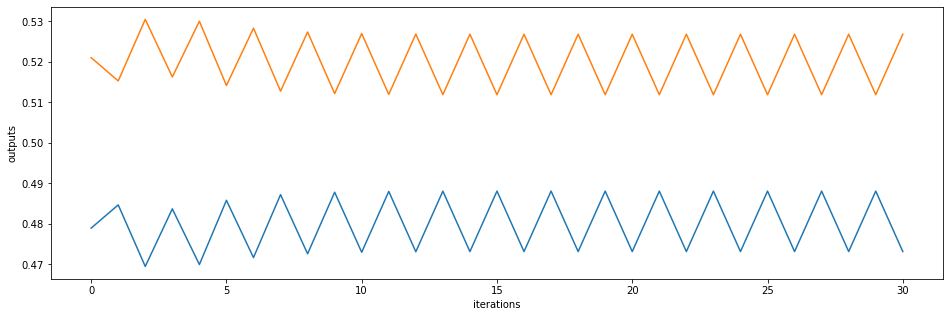

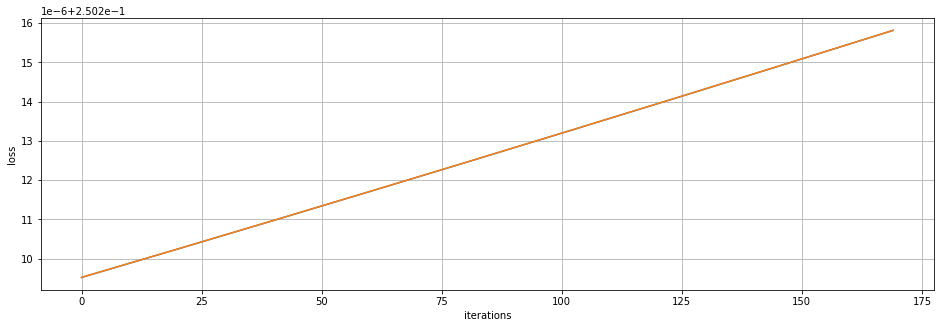

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 511
---------------
epoch 512
---------------
epoch 513
---------------
epoch 514
---------------
epoch 515
---------------
epoch 516
---------------
epoch 517
---------------
epoch 518
---------------
epoch 519
---------------
epoch 520
---------------
epoch 520
learning rate: 0.017557804503063105
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021624]
 [0.25021624]]


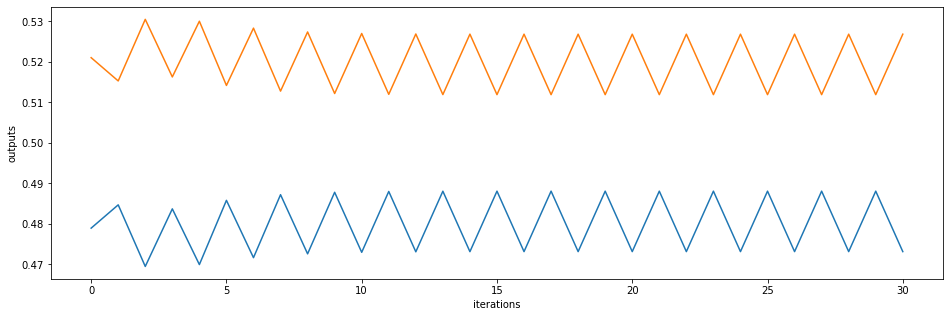

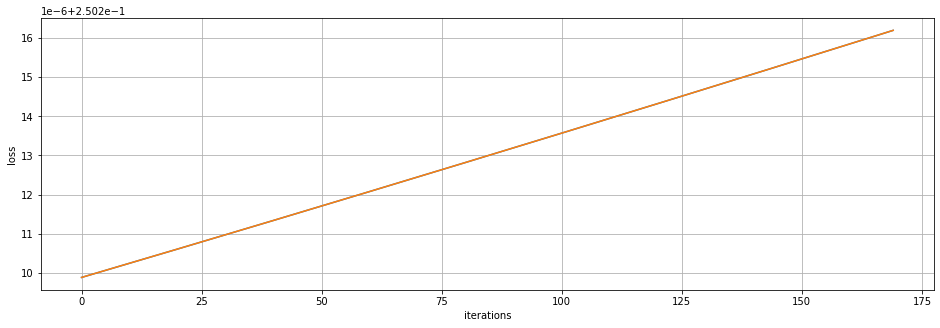

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 521
---------------
epoch 522
---------------
epoch 523
---------------
epoch 524
---------------
epoch 525
---------------
epoch 526
---------------
epoch 527
---------------
epoch 528
---------------
epoch 529
---------------
epoch 530
---------------
epoch 530
learning rate: 0.017513970286452466
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021662]
 [0.25021662]]


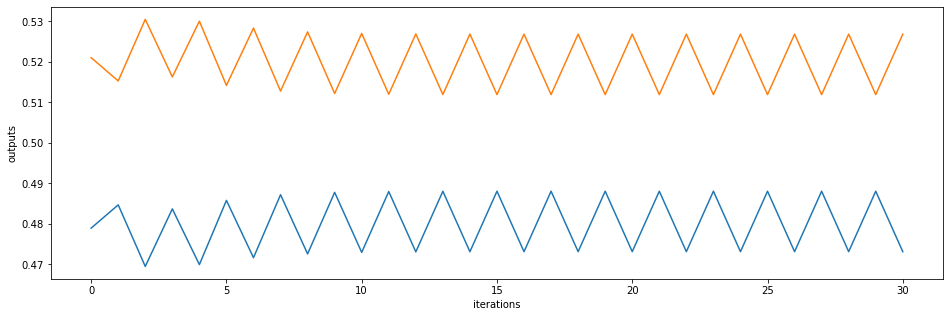

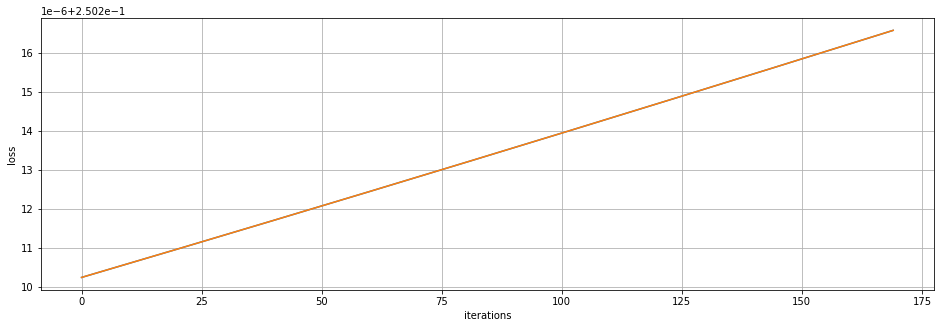

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 531
---------------
epoch 532
---------------
epoch 533
---------------
epoch 534
---------------
epoch 535
---------------
epoch 536
---------------
epoch 537
---------------
epoch 538
---------------
epoch 539
---------------
epoch 540
---------------
epoch 540
learning rate: 0.017470245504853786
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021701]
 [0.25021701]]


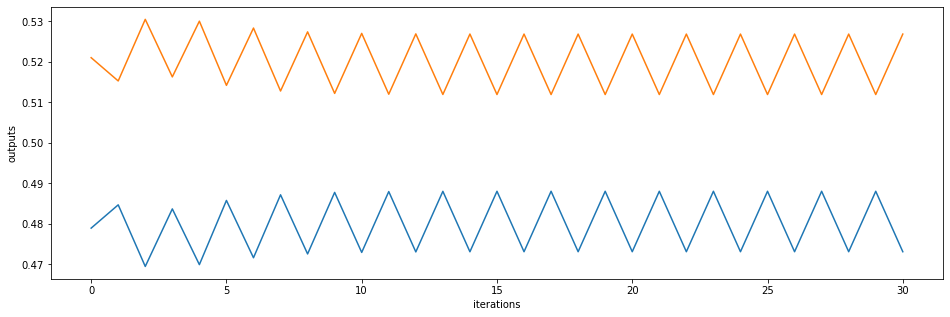

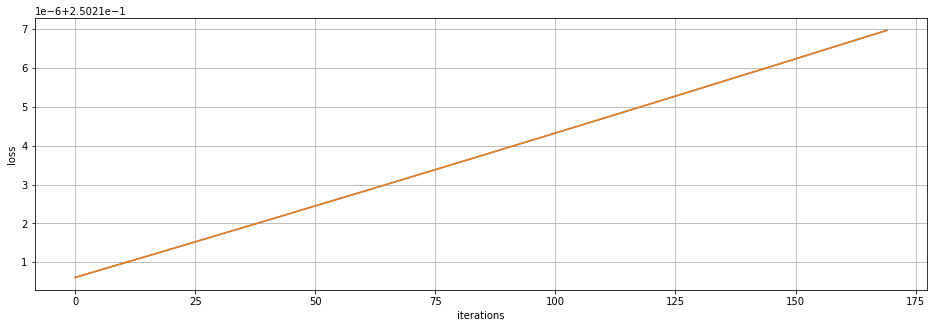

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 541
---------------
epoch 542
---------------
epoch 543
---------------
epoch 544
---------------
epoch 545
---------------
epoch 546
---------------
epoch 547
---------------
epoch 548
---------------
epoch 549
---------------
epoch 550
---------------
epoch 550
learning rate: 0.01742662988505535
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2502174]
 [0.2502174]]


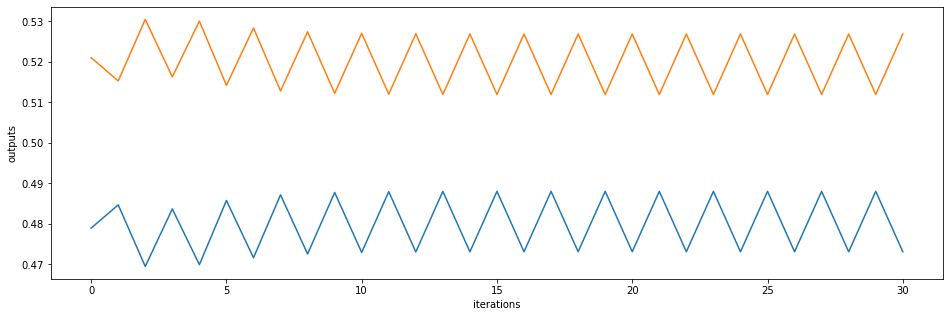

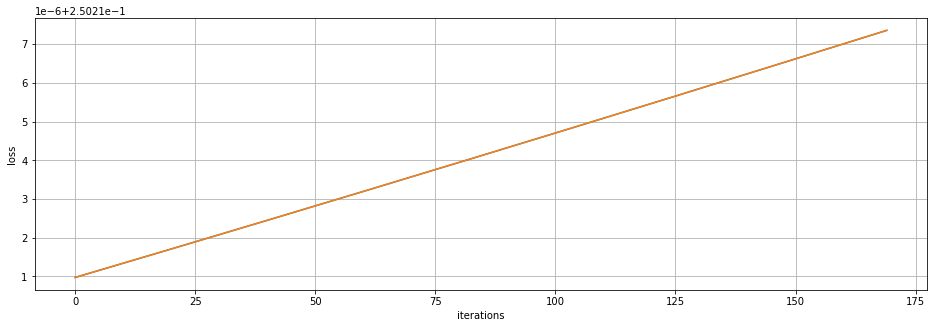

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 551
---------------
epoch 552
---------------
epoch 553
---------------
epoch 554
---------------
epoch 555
---------------
epoch 556
---------------
epoch 557
---------------
epoch 558
---------------
epoch 559
---------------
epoch 560
---------------
epoch 560
learning rate: 0.017383123154527523
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021779]
 [0.25021779]]


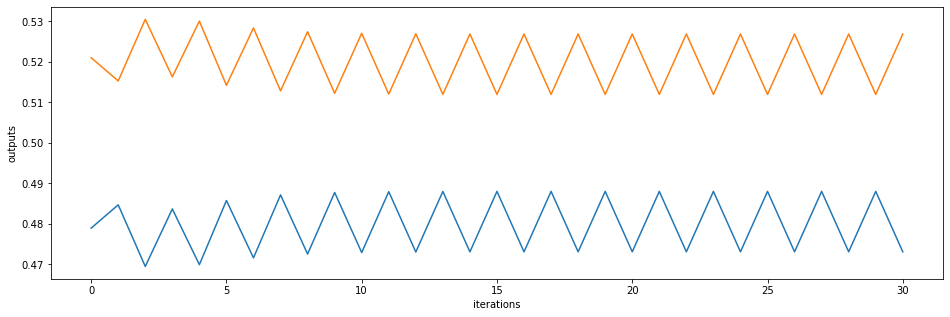

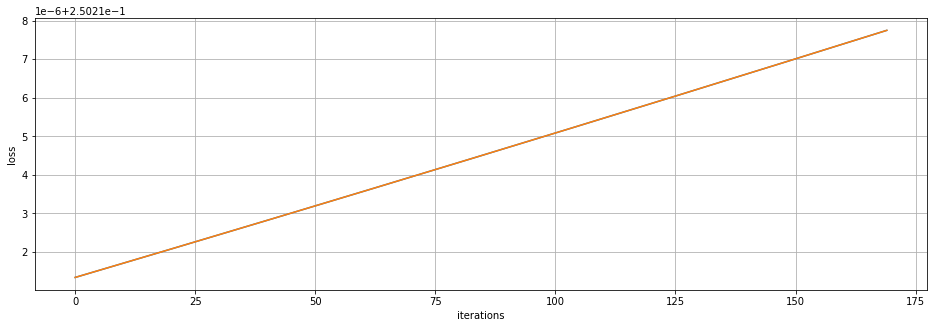

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 561
---------------
epoch 562
---------------
epoch 563
---------------
epoch 564
---------------
epoch 565
---------------
epoch 566
---------------
epoch 567
---------------
epoch 568
---------------
epoch 569
---------------
epoch 570
---------------
epoch 570
learning rate: 0.01733972504142107
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021818]
 [0.25021818]]


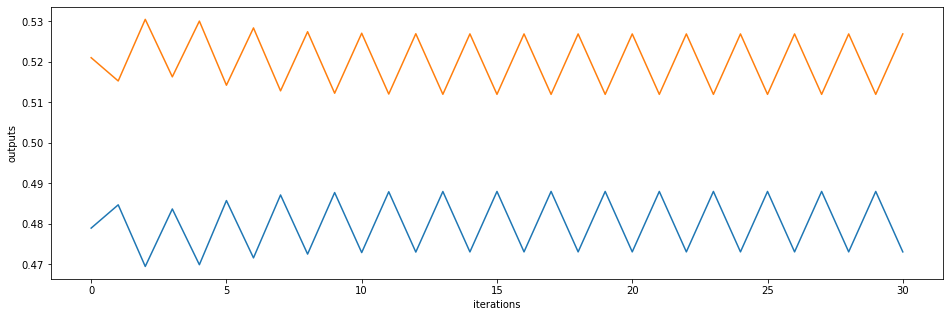

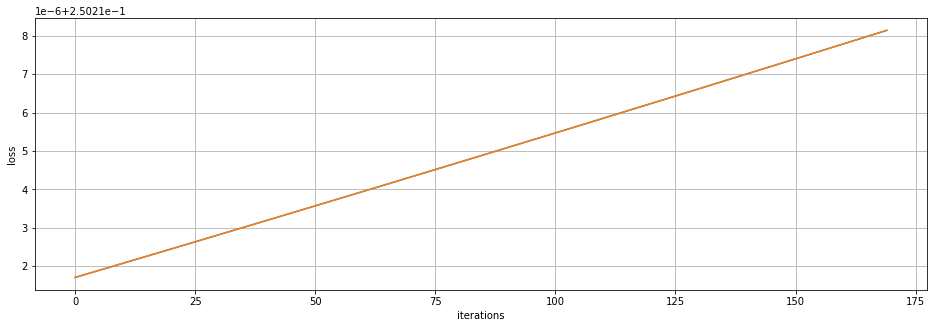

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 571
---------------
epoch 572
---------------
epoch 573
---------------
epoch 574
---------------
epoch 575
---------------
epoch 576
---------------
epoch 577
---------------
epoch 578
---------------
epoch 579
---------------
epoch 580
---------------
epoch 580
learning rate: 0.01729643527456543
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021857]
 [0.25021857]]


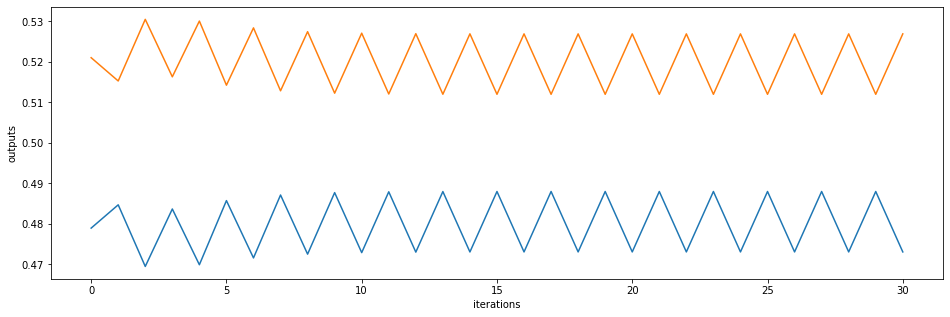

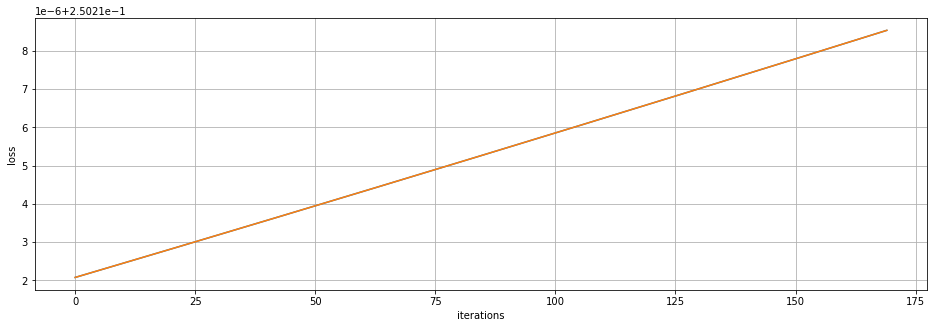

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 581
---------------
epoch 582
---------------
epoch 583
---------------
epoch 584
---------------
epoch 585
---------------
epoch 586
---------------
epoch 587
---------------
epoch 588
---------------
epoch 589
---------------
epoch 590
---------------
epoch 590
learning rate: 0.017253253583467038
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021896]
 [0.25021896]]


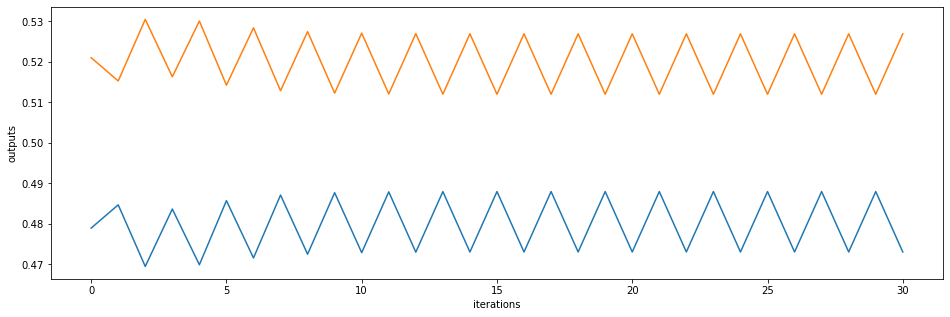

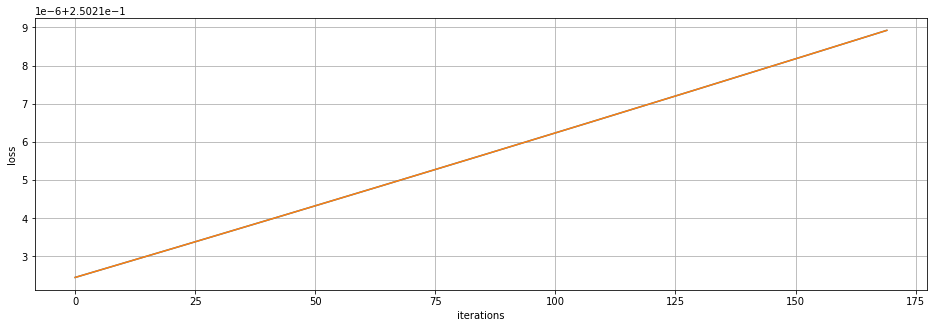

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 591
---------------
epoch 592
---------------
epoch 593
---------------
epoch 594
---------------
epoch 595
---------------
epoch 596
---------------
epoch 597
---------------
epoch 598
---------------
epoch 599
---------------
epoch 600
---------------
epoch 600
learning rate: 0.01721017969830764
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021936]
 [0.25021936]]


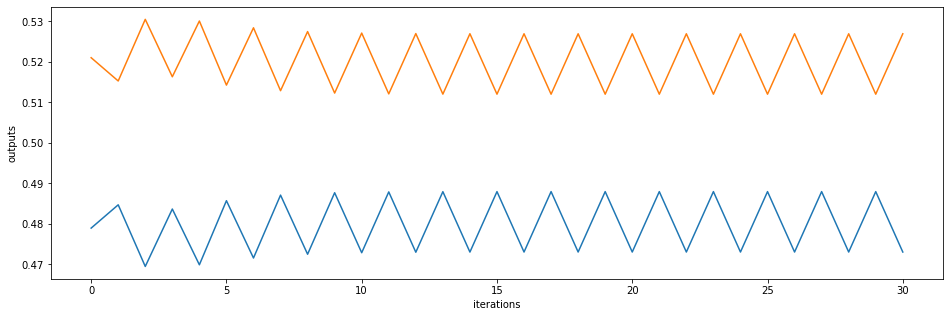

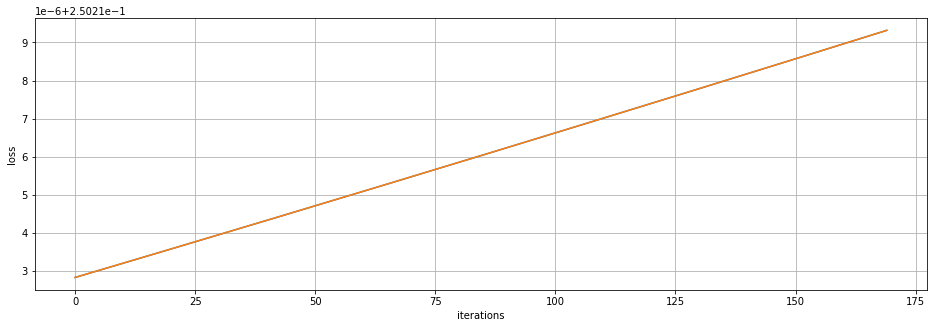

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 601
---------------
epoch 602
---------------
epoch 603
---------------
epoch 604
---------------
epoch 605
---------------
epoch 606
---------------
epoch 607
---------------
epoch 608
---------------
epoch 609
---------------
epoch 610
---------------
epoch 610
learning rate: 0.01716721334994261
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25021975]
 [0.25021975]]


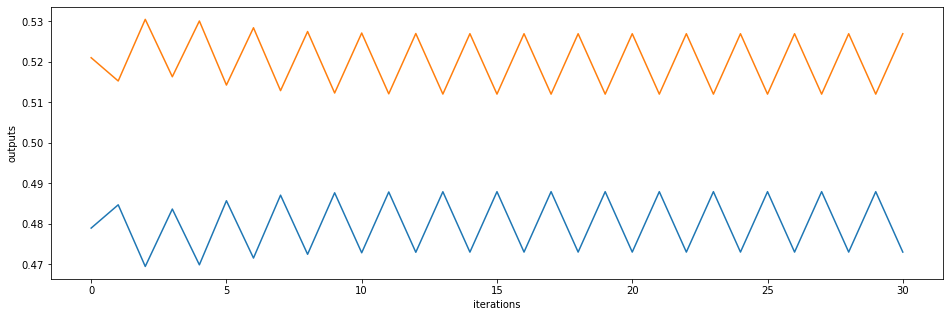

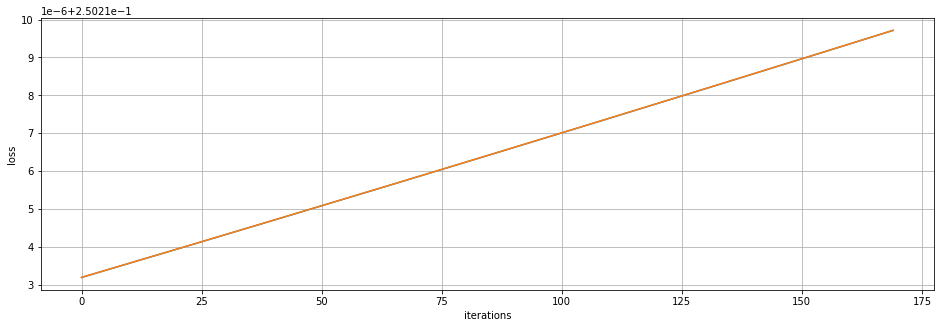

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 611
---------------
epoch 612
---------------
epoch 613
---------------
epoch 614
---------------
epoch 615
---------------
epoch 616
---------------
epoch 617
---------------
epoch 618
---------------
epoch 619
---------------
epoch 620
---------------
epoch 620
learning rate: 0.017124354269899247
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022015]
 [0.25022015]]


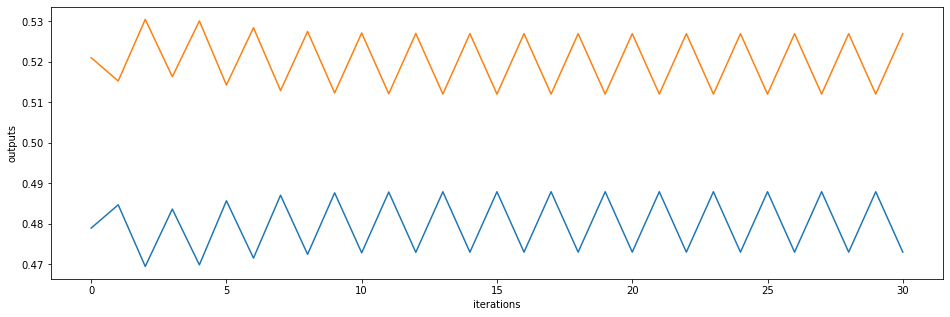

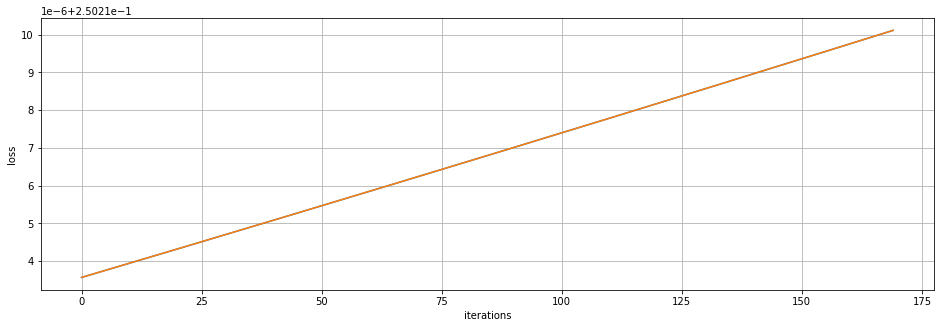

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 621
---------------
epoch 622
---------------
epoch 623
---------------
epoch 624
---------------
epoch 625
---------------
epoch 626
---------------
epoch 627
---------------
epoch 628
---------------
epoch 629
---------------
epoch 630
---------------
epoch 630
learning rate: 0.017081602190375116
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022055]
 [0.25022055]]


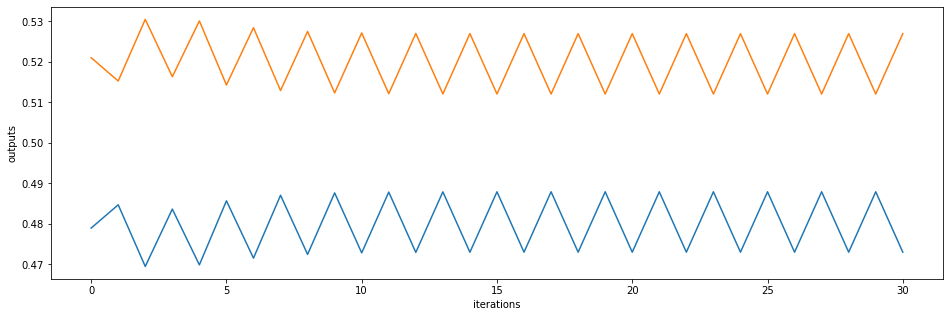

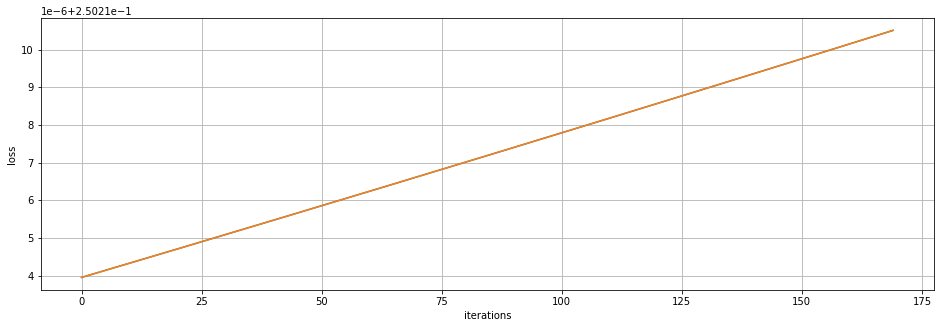

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 631
---------------
epoch 632
---------------
epoch 633
---------------
epoch 634
---------------
epoch 635
---------------
epoch 636
---------------
epoch 637
---------------
epoch 638
---------------
epoch 639
---------------
epoch 640
---------------
epoch 640
learning rate: 0.017038956844236362
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022095]
 [0.25022095]]


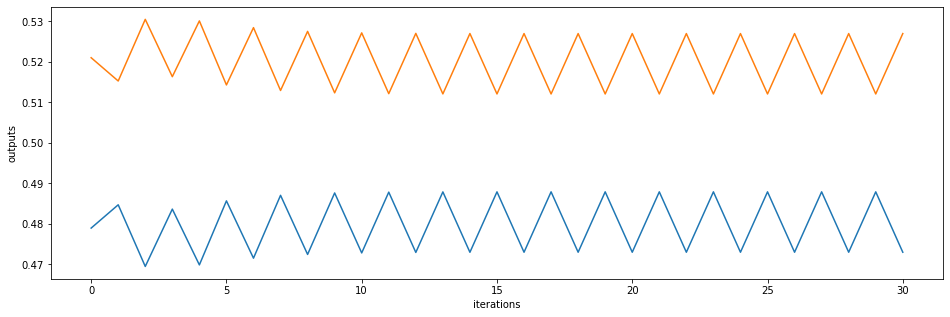

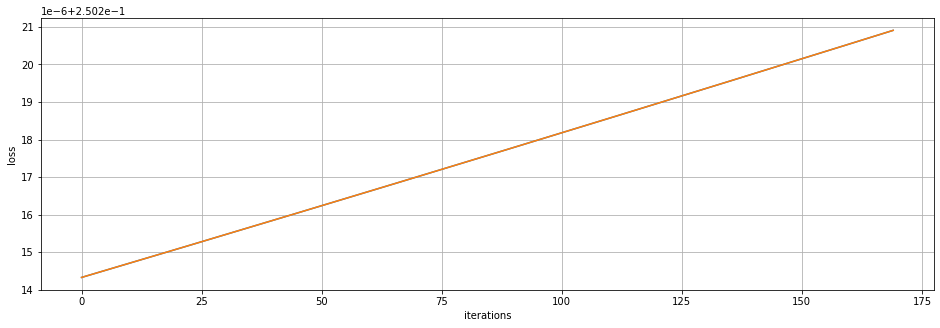

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 641
---------------
epoch 642
---------------
epoch 643
---------------
epoch 644
---------------
epoch 645
---------------
epoch 646
---------------
epoch 647
---------------
epoch 648
---------------
epoch 649
---------------
epoch 650
---------------
epoch 650
learning rate: 0.016996417965016053
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022135]
 [0.25022135]]


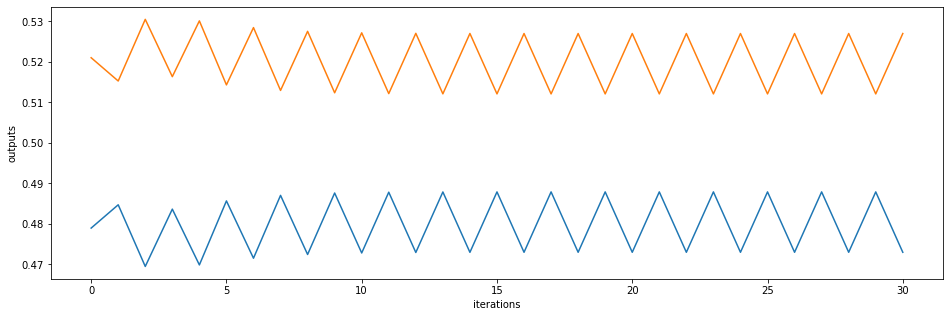

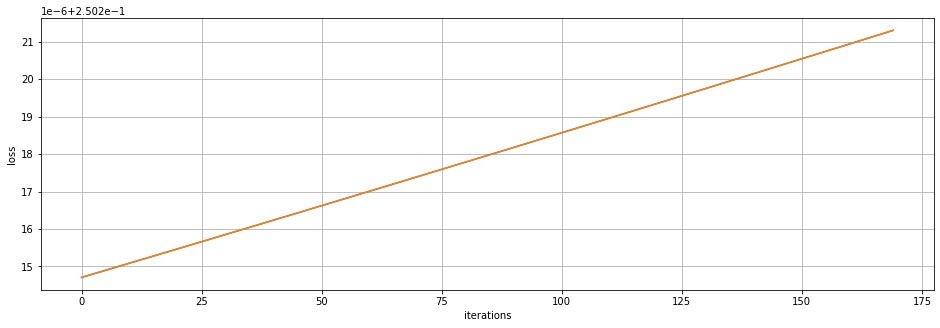

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 651
---------------
epoch 652
---------------
epoch 653
---------------
epoch 654
---------------
epoch 655
---------------
epoch 656
---------------
epoch 657
---------------
epoch 658
---------------
epoch 659
---------------
epoch 660
---------------
epoch 660
learning rate: 0.016953985286912502
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022175]
 [0.25022175]]


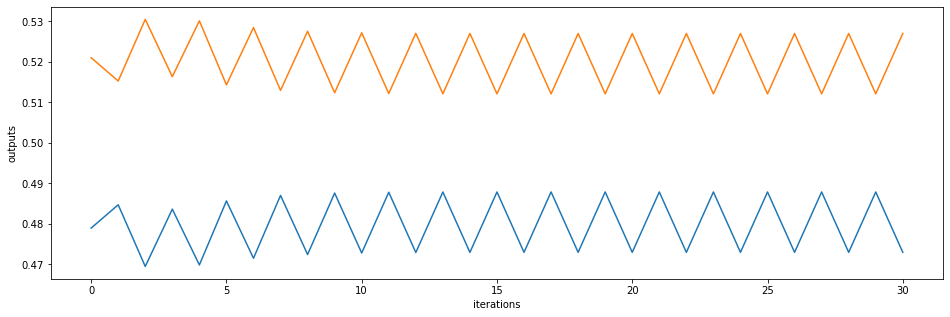

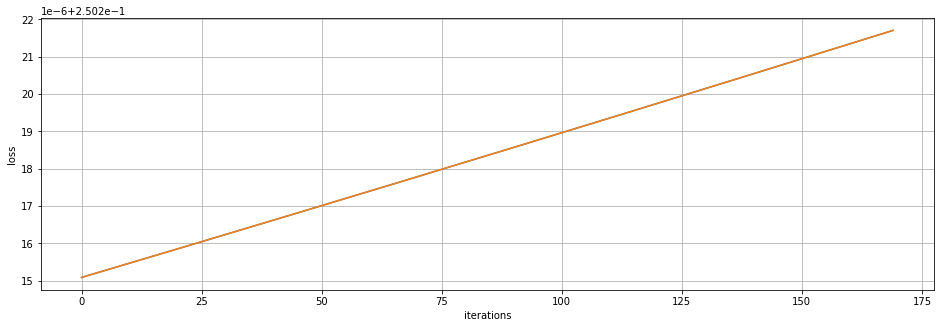

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 661
---------------
epoch 662
---------------
epoch 663
---------------
epoch 664
---------------
epoch 665
---------------
epoch 666
---------------
epoch 667
---------------
epoch 668
---------------
epoch 669
---------------
epoch 670
---------------
epoch 670
learning rate: 0.016911658544787624
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022215]
 [0.25022215]]


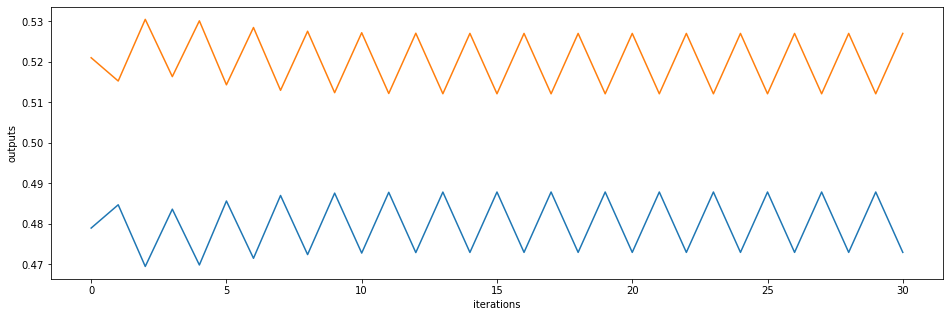

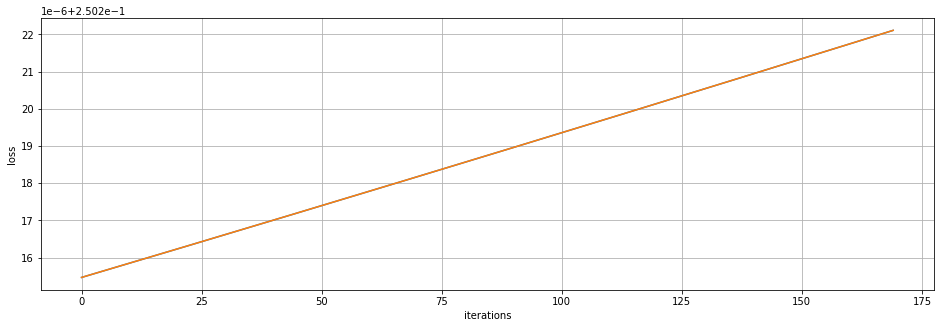

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 671
---------------
epoch 672
---------------
epoch 673
---------------
epoch 674
---------------
epoch 675
---------------
epoch 676
---------------
epoch 677
---------------
epoch 678
---------------
epoch 679
---------------
epoch 680
---------------
epoch 680
learning rate: 0.016869437474165264
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022255]
 [0.25022255]]


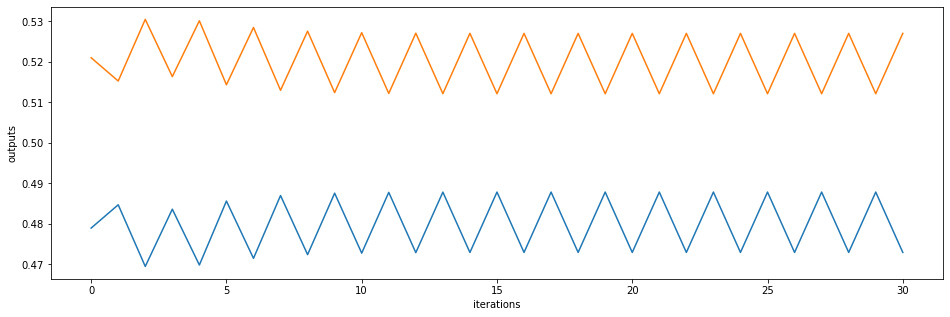

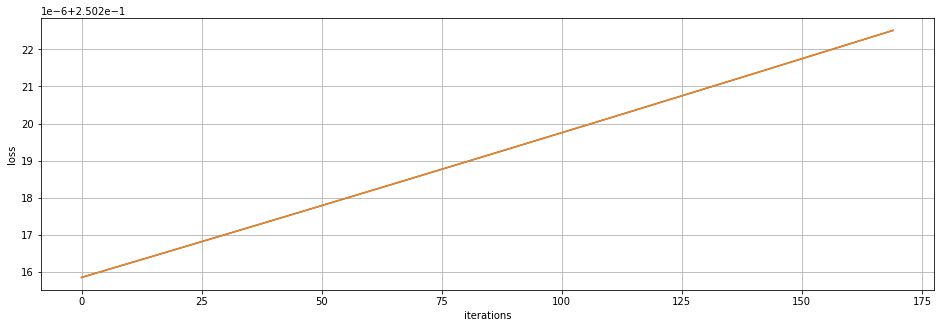

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 681
---------------
epoch 682
---------------
epoch 683
---------------
epoch 684
---------------
epoch 685
---------------
epoch 686
---------------
epoch 687
---------------
epoch 688
---------------
epoch 689
---------------
epoch 690
---------------
epoch 690
learning rate: 0.016827321811229545
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022296]
 [0.25022296]]


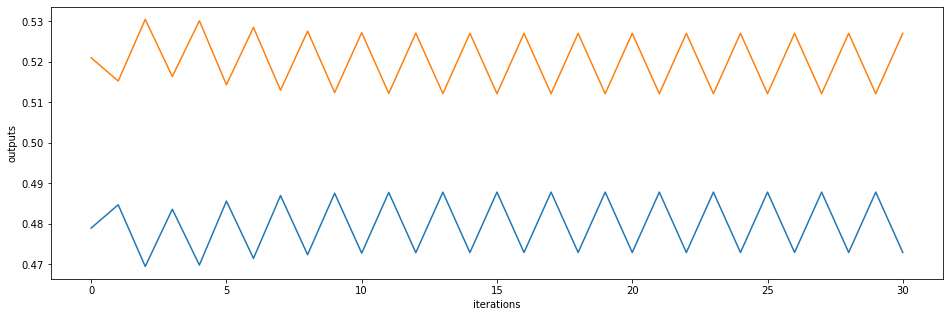

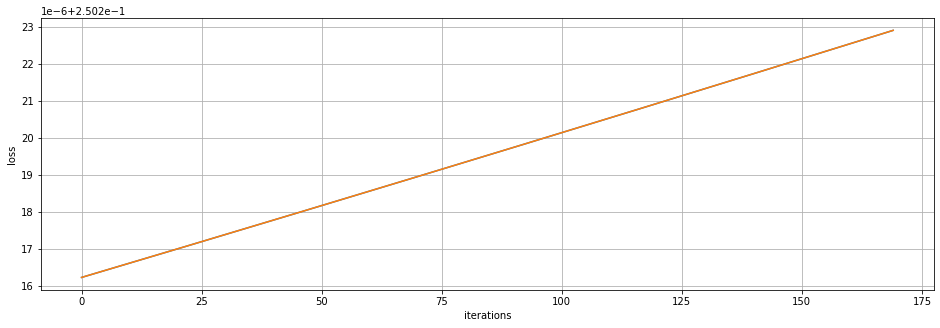

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 691
---------------
epoch 692
---------------
epoch 693
---------------
epoch 694
---------------
epoch 695
---------------
epoch 696
---------------
epoch 697
---------------
epoch 698
---------------
epoch 699
---------------
epoch 700
---------------
epoch 700
learning rate: 0.01678531129282323
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022336]
 [0.25022336]]


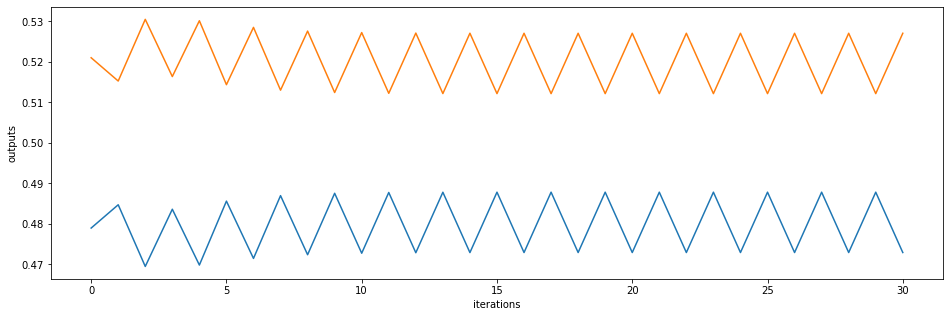

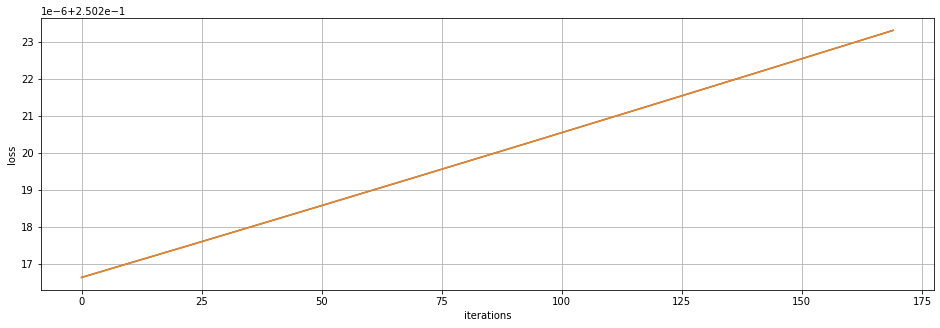

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 701
---------------
epoch 702
---------------
epoch 703
---------------
epoch 704
---------------
epoch 705
---------------
epoch 706
---------------
epoch 707
---------------
epoch 708
---------------
epoch 709
---------------
epoch 710
---------------
epoch 710
learning rate: 0.016743405656446067
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022377]
 [0.25022377]]


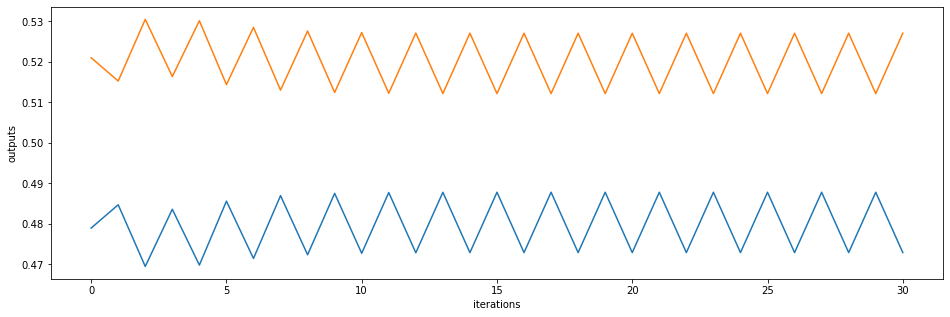

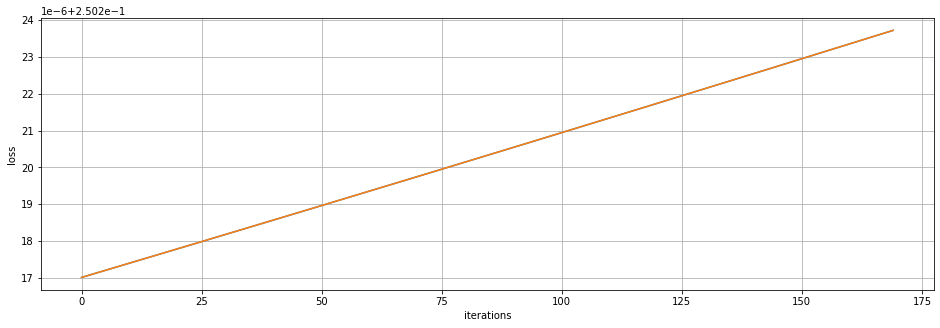

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 711
---------------
epoch 712
---------------
epoch 713
---------------
epoch 714
---------------
epoch 715
---------------
epoch 716
---------------
epoch 717
---------------
epoch 718
---------------
epoch 719
---------------
epoch 720
---------------
epoch 720
learning rate: 0.016701604640253154
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022417]
 [0.25022417]]


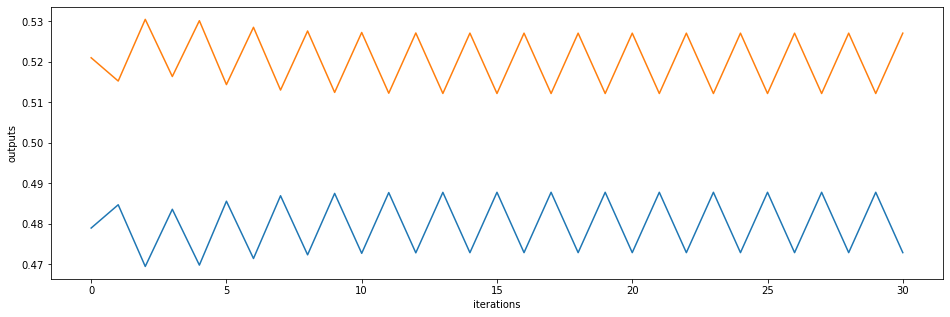

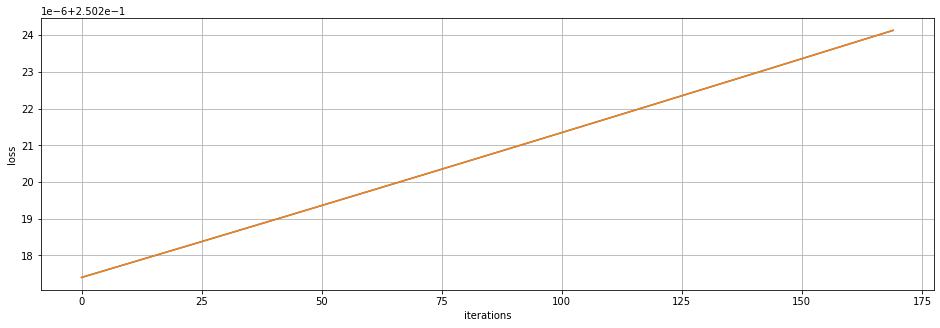

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 721
---------------
epoch 722
---------------
epoch 723
---------------
epoch 724
---------------
epoch 725
---------------
epoch 726
---------------
epoch 727
---------------
epoch 728
---------------
epoch 729
---------------
epoch 730
---------------
epoch 730
learning rate: 0.016659907983053307
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022458]
 [0.25022458]]


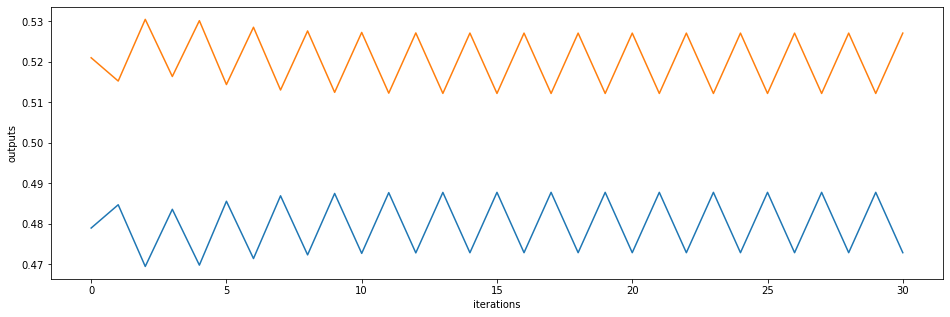

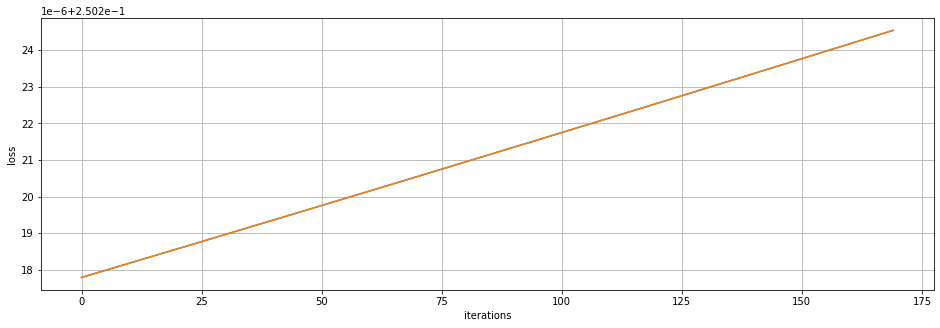

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 731
---------------
epoch 732
---------------
epoch 733
---------------
epoch 734
---------------
epoch 735
---------------
epoch 736
---------------
epoch 737
---------------
epoch 738
---------------
epoch 739
---------------
epoch 740
---------------
epoch 740
learning rate: 0.016618315424307414
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022499]
 [0.25022499]]


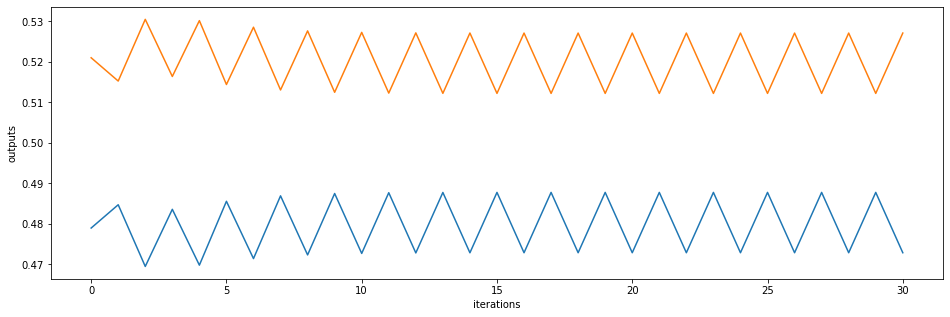

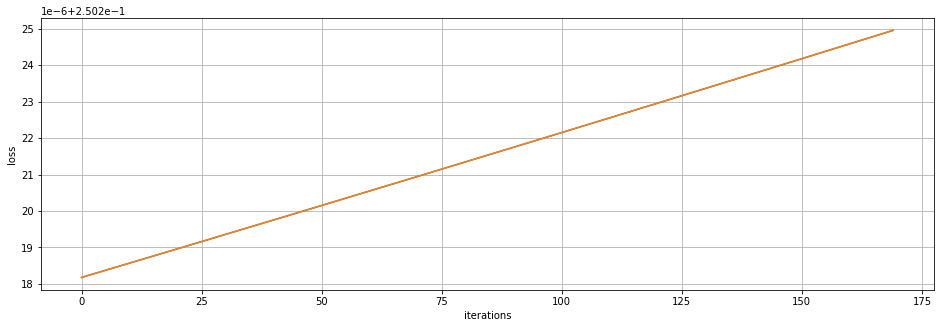

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 741
---------------
epoch 742
---------------
epoch 743
---------------
epoch 744
---------------
epoch 745
---------------
epoch 746
---------------
epoch 747
---------------
epoch 748
---------------
epoch 749
---------------
epoch 750
---------------
epoch 750
learning rate: 0.01657682670412683
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.2502254]
 [0.2502254]]


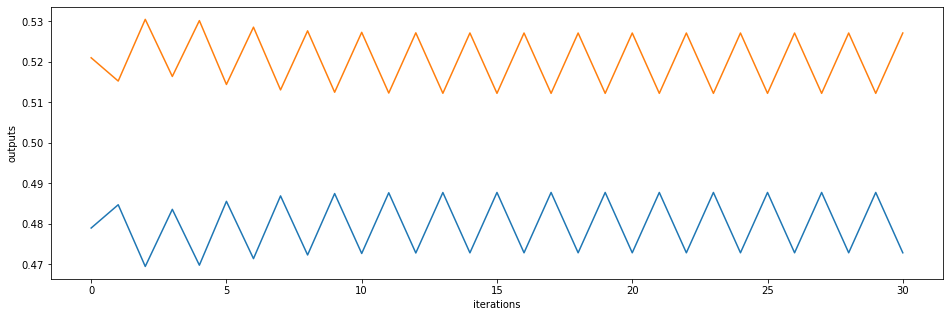

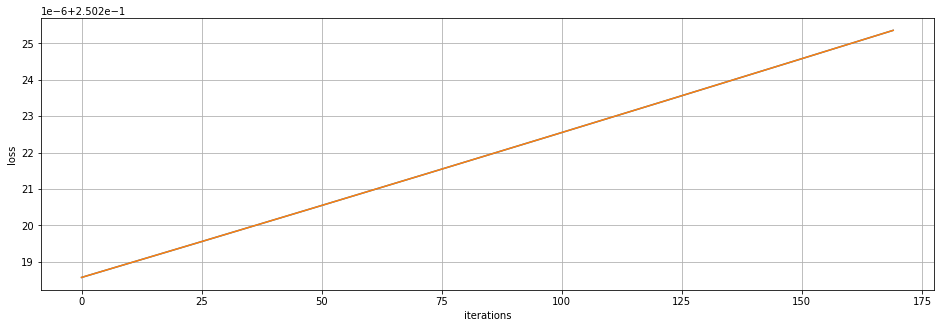

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 751
---------------
epoch 752
---------------
epoch 753
---------------
epoch 754
---------------
epoch 755
---------------
epoch 756
---------------
epoch 757
---------------
epoch 758
---------------
epoch 759
---------------
epoch 760
---------------
epoch 760
learning rate: 0.016535441563271722
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022581]
 [0.25022581]]


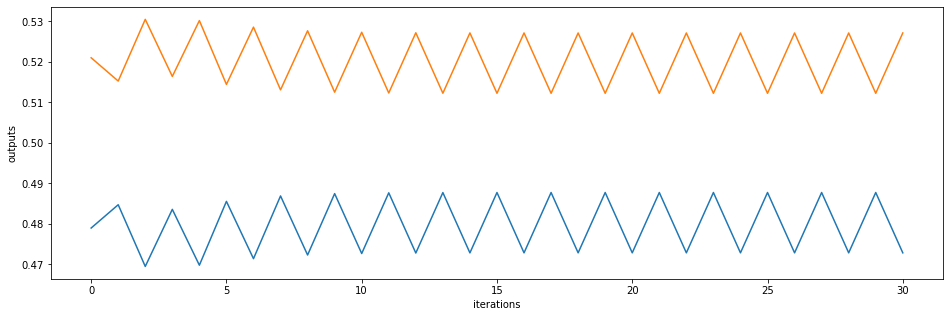

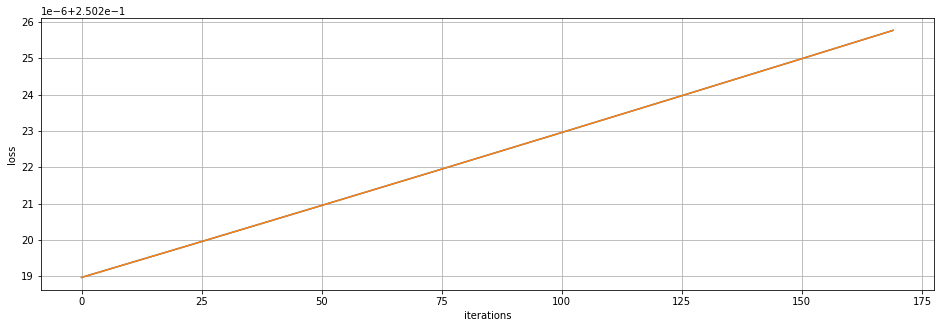

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 761
---------------
epoch 762
---------------
epoch 763
---------------
epoch 764
---------------
epoch 765
---------------
epoch 766
---------------
epoch 767
---------------
epoch 768
---------------
epoch 769
---------------
epoch 770
---------------
epoch 770
learning rate: 0.016494159743149474
sample 0
output: 
[[0.47896425]
 [0.52103575]]
target: 
[[1], [0]]
-----------------
average loss: 
[[0.25022622]
 [0.25022622]]


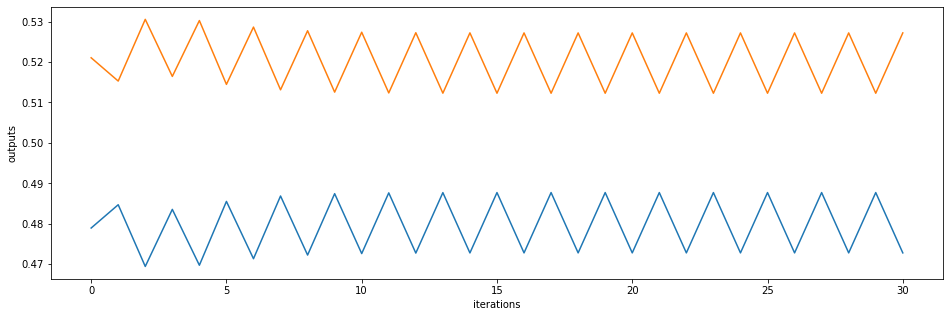

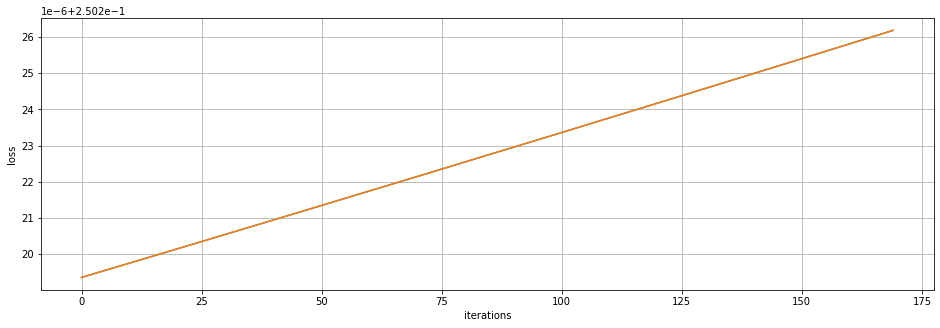

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 771
---------------
epoch 772
---------------

In [ ]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.00025
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 24)
  
        if e%10 == 0 and i%131 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%10 == 0:        
        print("-----------------")
        print("average loss: ")
        print(str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    if e > 10:
        losses.append(loss/len(input_data))
    if e > 180:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-1].weights_H))

In [ ]:
print(str(network.layers[-2].weights_X))

In [ ]:
print(str(network.layers[-2].H))